# Preparation

In [1]:
sessionInfo()
set.seed(1)
.libPaths()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/INIM/vladyslav.kavaka/miniconda3/envs/azimuth/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_1.0.3     crayon_1.4.2    digest_0.6.29   utf8_1.2.2     
 [5] IRdisplay_1.1   repr_1.1.4      lifecycle_1.0.3 jsonlite_1.7.2 
 [9] evaluate_0.14   pillar_1.8.1    rlang_1.0.6     cli_3.4.1      
[13] uuid_1.0-3      vctrs_0.5.1     IRkernel_1.3    tools_4.0.5    
[17] glue_1.6.2      fastmap_1.1.0   compiler_4.0.5  base64enc_0.1-3
[21] pbdZMQ_0.3-6  

[1] "/home/INIM/vladyslav.kavaka/miniconda3/envs/azimuth/lib/R/library"

## Imports

In [2]:
.libPaths('/home/INIM/vladyslav.kavaka/miniconda3/envs/seurat_neb/lib/R/library')
library(devtools)
library(Seurat)
library(dplyr)
library(Matrix)
library(tidyr)
library(limma)
library(ggplot2)
library(ggthemes)
library(patchwork)
library(gprofiler2)
library(ggrepel)
library(scales)
library(ggthemes)
library(purrr)
library(MAST)
library(qpcR)
library(enrichR)
library(harmony)
library(Nebulosa)
library(celldex)

Loading required package: usethis



## Custom Utility Functions

The figsize in R is specified in inches, 1 inch = 2.54 cm.

In [4]:
set_figsize <- function(width, height){
    options(repr.plot.width = width, 
            repr.plot.height = height)
}

# Load in the data

In [18]:
#load in the data, explore the structure

load('~/shares/projects/pro_Beltran/Vlad/Hodgkin_202202/dataset_sc_Steidl/EGAF00004049210/HL_merged_sc_obj/HL_merged_sc_obj.Rdata')

# Create Seurat object

In [20]:
obj <- as.Seurat(sc.obj, counts = 'counts')

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from PC to PC_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to PC_”


In [21]:
obj <- RenameAssays(obj, originalexp = 'RNA')

Renaming default assay from originalexp to RNA

Warning message:
“Cannot add objects with duplicate keys (offending key: originalexp_) setting key to original value 'rna_'”


In [22]:
obj <- DietSeurat(obj, assays = 'RNA', counts = TRUE, scale.data = FALSE, dimreducs = NULL, graphs = NULL)

In [23]:
obj

An object of class Seurat 
33694 features across 127786 samples within 1 assay 
Active assay: RNA (33694 features, 0 variable features)

## QC

In [24]:
# The number of features and UMIs (nFeature_RNA and nCount_RNA) are automatically calculated for every object by Seurat.
# For non-UMI data, nCount_RNA represents the sum of the non-normalized values within a cell
# We calculate the percentage of mitochondrial features here and store it in object metadata as `percent.mito`.
# We use raw count data since this represents non-transformed and non-log-normalized counts
# The % of UMI mapping to MT-features is a common scRNA-seq QC metric.
mito.features <- grep(pattern = "^MT-", x = rownames(x = obj), value = TRUE)
percent.mito <- Matrix::colSums(x = GetAssayData(object = obj, slot = 'counts')[mito.features, ]) / Matrix::colSums(x = GetAssayData(object = obj, slot = 'counts'))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



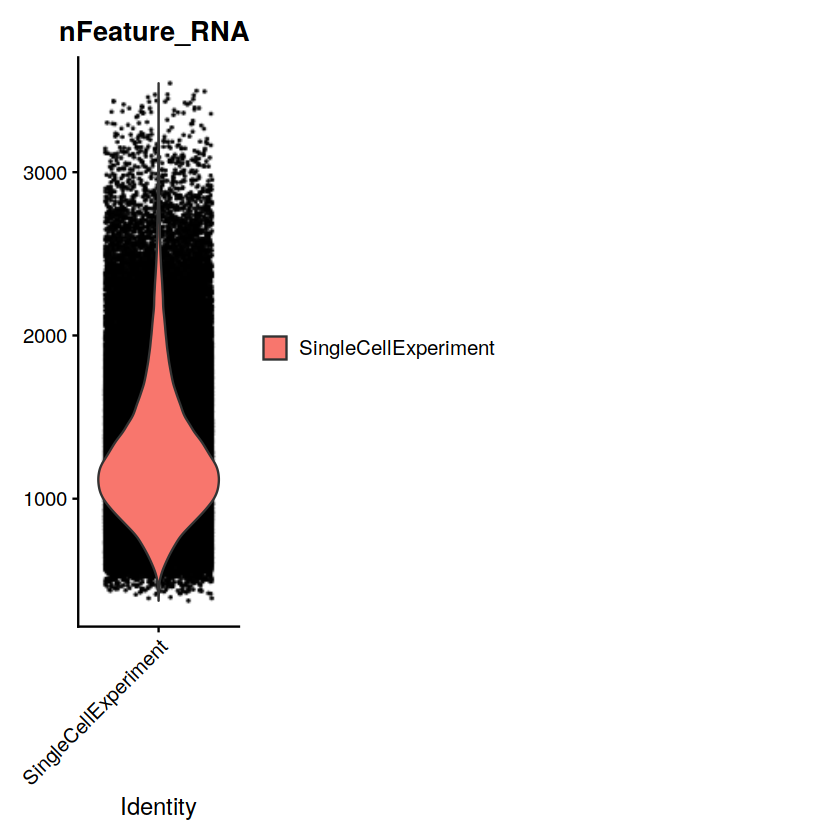

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



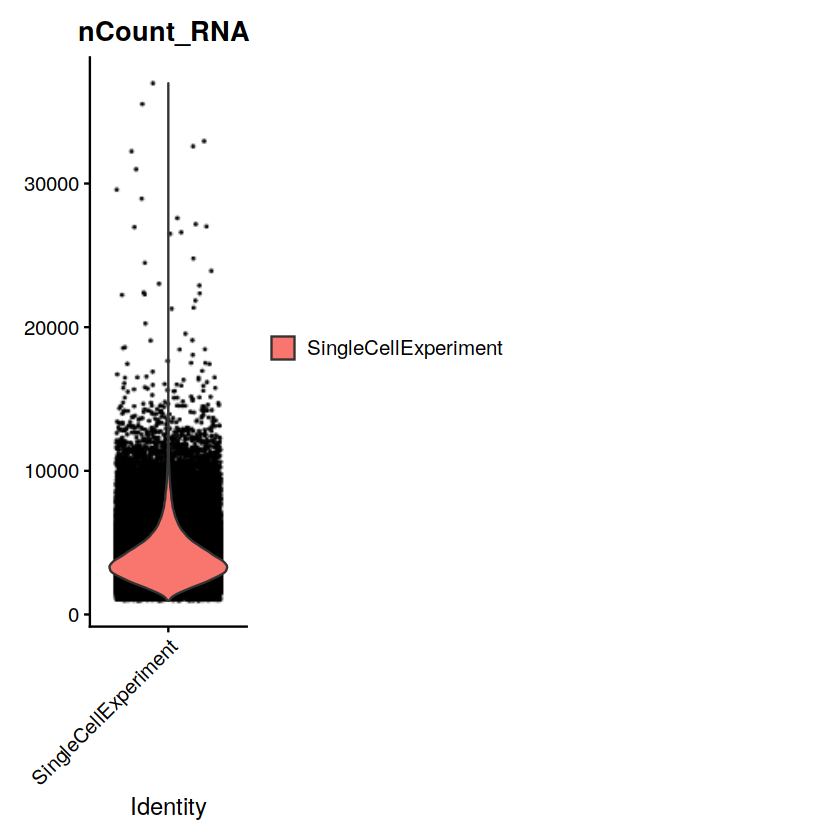

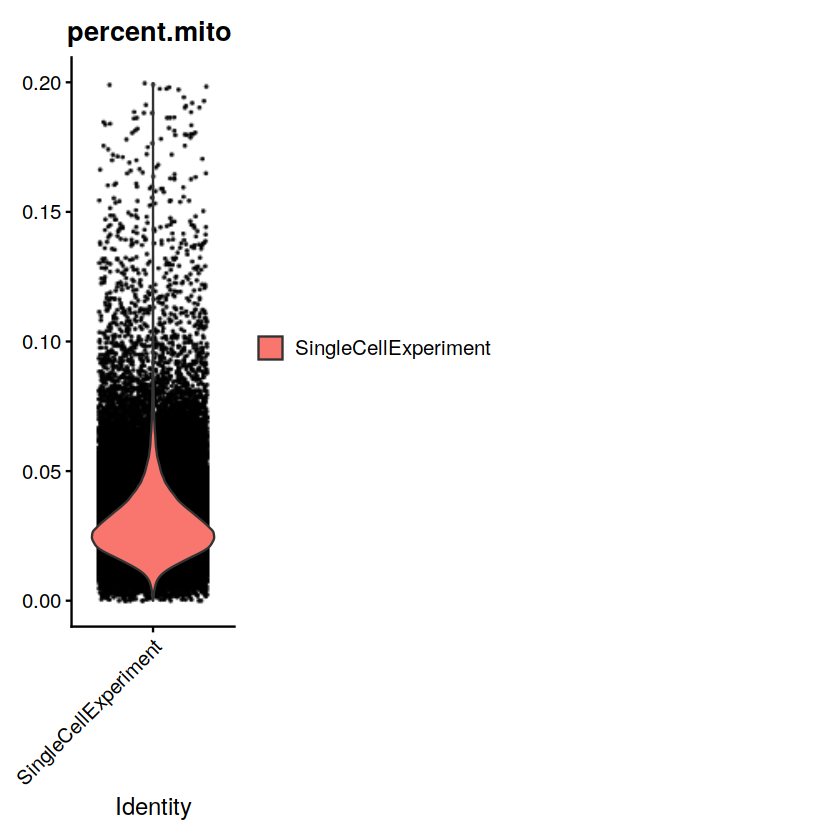

In [25]:
# The [[ operator can add columns to object metadata, and is a great place to stash QC stats
obj[['percent.mito']] <- percent.mito
plot <- VlnPlot(object = obj, features = c("nFeature_RNA"), ncol = 3, pt.size = 0.000001)
l1 <- plot$layers[[1]]
l2 <- plot$layers[[2]]

plot$layers[[1]] <- l2
plot$layers[[2]] <- l1

plot

plot <- VlnPlot(object = obj, features = c("nCount_RNA"), ncol = 3, pt.size = 0.000001)
l1 <- plot$layers[[1]]
l2 <- plot$layers[[2]]

plot$layers[[1]] <- l2
plot$layers[[2]] <- l1

plot

plot <- VlnPlot(object = obj, features = c("percent.mito"), ncol = 3, pt.size = 0.000001)
l1 <- plot$layers[[1]]
l2 <- plot$layers[[2]]

plot$layers[[1]] <- l2
plot$layers[[2]] <- l1

plot

# Integration

In [34]:
obj@meta.data$sample <- obj@meta.data$dataset
unique(obj$sample)

[1] "CHL08"    "CHL09"    "CHL03"    "CHL13"    "CHL02"    "CHL07"   
 [7] "CHL12"    "CHL05"    "CHL06"    "CHL15"    "CHL14"    "CHL04"   
[13] "CHL01"    "CHL11"    "CHL10"    "CHL18"    "CHL17"    "CHL19"   
[19] "CHL16"    "CHL20"    "CHL21"    "CHL22"    "RLN-1_R1" "RLN-1_R2"
[25] "RLN-2"    "RLN-3"    "RLN-4"    "RLN-5"

In [37]:
Sys.time()
obj.list <- SplitObject(obj, split.by = "sample")

[1] "2022-05-01 10:24:21 UTC"

In [38]:
markers.remove <- grep(pattern = c("^TRAV|^TRBV|^TRGV|^TRDV|^IGKV|^IGLV|^IGHV|^IGHG|^IGK"),  x = rownames(x = obj), value = TRUE)

In [39]:
obj.list <- lapply(X = obj.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 3000)
})

for (i in 1:length(obj.list)){
     VariableFeatures(obj.list[[i]]) <- VariableFeatures(object = obj.list[[i]])[!(VariableFeatures(object = obj.list[[i]])%in%markers.remove)]
}
Sys.time()

[1] "2022-05-01 10:25:36 UTC"

In [40]:
features <- SelectIntegrationFeatures(object.list = obj.list, nfeatures = 2500)

In [41]:
Sys.time()

[1] "2022-05-01 10:25:39 UTC"

In [42]:
obj.list <- lapply(X = obj.list, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose = FALSE)
    x <- RunPCA(x, features = features, verbose = FALSE)
})
Sys.time()

[1] "2022-05-01 10:28:26 UTC"

In [43]:
obj.anchors <- FindIntegrationAnchors(object.list = obj.list, anchor.features = features, reduction = "rpca")
Sys.time()

Scaling features for provided objects

Computing within dataset neighborhoods

Finding all pairwise anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1668 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1584 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 2510 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1741 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 2341 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 2351 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1125 anchors

Projecting new data onto SVD

Projecting new

[1] "2022-05-01 10:57:45 UTC"

In [44]:
obj.integrated <- IntegrateData(anchorset = obj.anchors)
Sys.time()

Merging dataset 23 into 24

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 1 into 18

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 17 into 18 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 4 into 6

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 9 into 22

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 15 into 18 1 17

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 10 into 3

Extracting anchors for merged samples

Finding integration vectors

Fi

[1] "2022-05-01 11:44:05 UTC"

In [45]:
obj.integrated

An object of class Seurat 
36194 features across 127686 samples within 2 assays 
Active assay: integrated (2500 features, 2500 variable features)
 1 other assay present: RNA

In [46]:
saveRDS(obj.integrated, file = './obj.integrated.withoutumap.rds')

# Working with integrated file

In [47]:
obj.integrated <- ScaleData(obj.integrated, features = VariableFeatures(object = obj.integrated), vars.to.regress = c("nCount_RNA", "percent.mito"))
obj.integrated <- RunPCA(obj.integrated, features = VariableFeatures(object = obj.integrated))

Regressing out nCount_RNA, percent.mito

Centering and scaling data matrix

PC_ 1 
Positive:  CD3D, IL32, TRAC, GIMAP7, CD2, FYB, GIMAP4, CD3E, CD7, CD3G 
	   SRGN, LAT, HCST, TRBC2, RARRES3, TRBC1, SYNE2, CD27, CD247, LCK 
	   SCGB3A1, PYHIN1, AAK1, TIGIT, SLFN5, ITM2A, SH2D1A, TBC1D4, TCF7, S100A4 
Negative:  HLA-DQA2, HLA-DRA, MS4A1, CD79A, HLA-DQB1, HLA-DRB1, HLA-DPB1, HLA-DPA1, HLA-DQA1, CD79B 
	   CD74, HLA-DMB, BANK1, MEF2C, HLA-DMA, CD22, VPREB3, IGHD, TCL1A, RALGPS2 
	   FCER2, SWAP70, IGHM, CD72, SMIM14, CD37, RP11-231C14.7, PHACTR1, ARHGAP24, EAF2 
PC_ 2 
Positive:  LINC00152, MIR4435-2HG, TNIP3, AC133644.2, TNFRSF18, LAG3, PTTG1, TIGIT, MAF, GAPDH 
	   CXCR6, CHI3L2, NUSAP1, CEBPA, TIMD4, ACTB, ICA1, DYNLL1, CST7, HLA-A 
	   IKZF3, CTLA4, CD38, SPATS2L, EZR, RNF19A, MYL6, HMGB2, MAGEH1, POU3F1 
Negative:  RPL13, RPS12, RPS6, RPL10, RPS18, RPS14, RPS3, RPL3, RPS8, EEF1A1 
	   TPT1, RPS2, RPLP1, IL7R, VIM, PLAC8, IER2, KLF2, RPLP0, CCR7 
	   NOSIP, SLC2A3, EMP3, TCF7, ZFP36L2

In [54]:
default_width <- 11
set_figsize(default_width, default_width)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



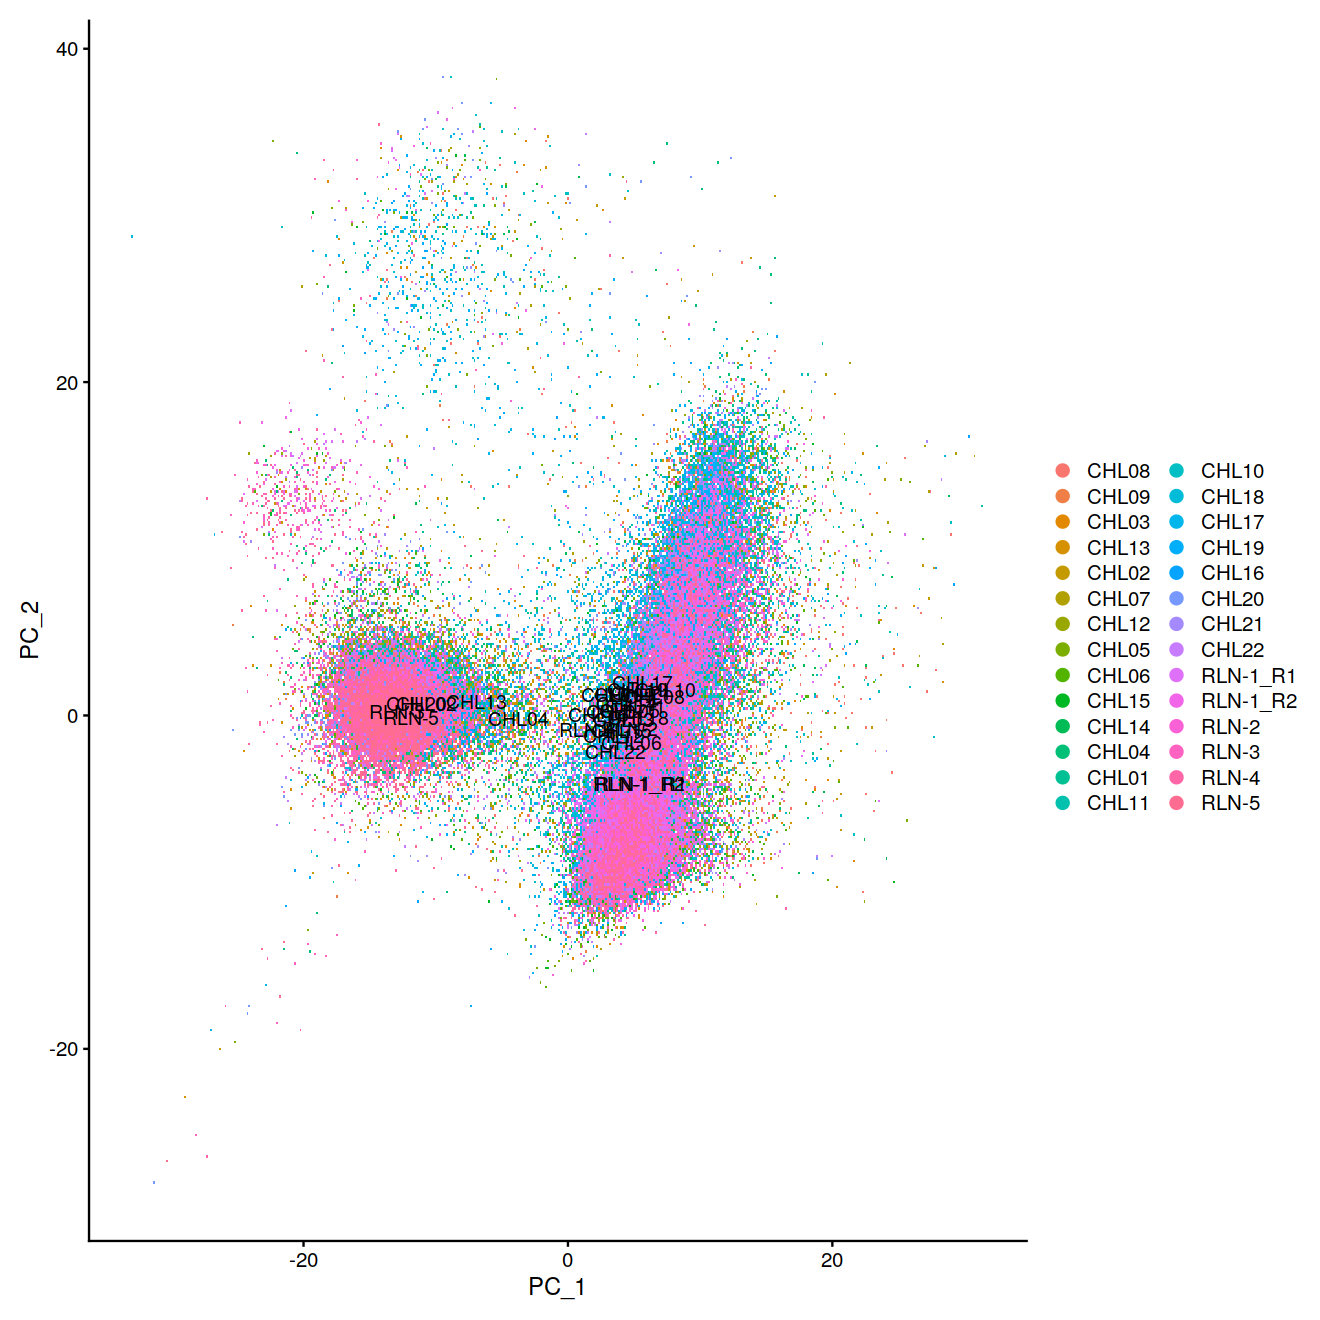

In [55]:
Idents(obj.integrated) <- 'sample'
DimPlot(obj.integrated, reduction = 'pca', label = TRUE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



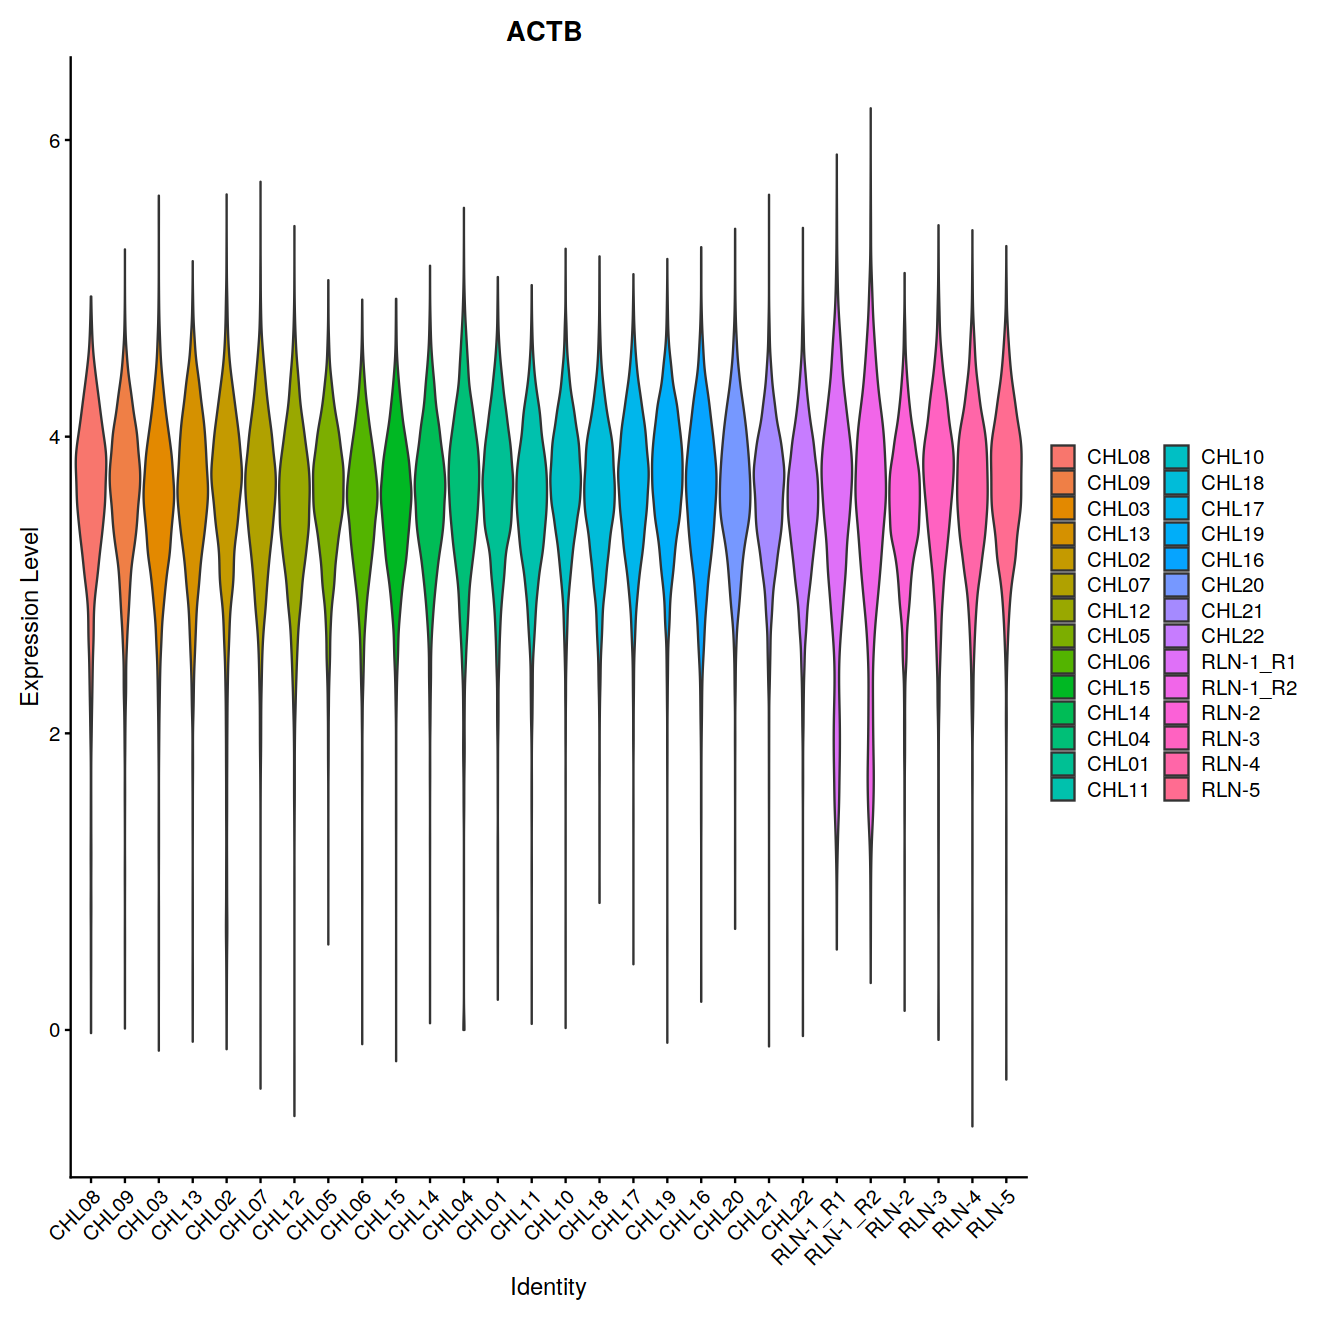

In [56]:
Idents(obj.integrated) <- 'sample'
VlnPlot(obj.integrated, "ACTB", pt.size = 0)

In [57]:
# ProjectDim scores each feature in the dataset (including features not included in the PCA) based on their correlation 
# with the calculated components. Though we don't use this further here, it can be used to identify markers that 
# are strongly correlated with cellular heterogeneity, but may not have passed through variable feature selection. 
# The results of the projected PCA can be explored by setting `projected = TRUE`in the functions above
obj.integrated <- ProjectDim(object = obj.integrated)

PC_ 1 
Positive:  CD3D, IL32, TRAC, GIMAP7, CD2, FYB, GIMAP4, CD3E, CD7, CD3G 
	   SRGN, LAT, HCST, TRBC2, RARRES3, TRBC1, SYNE2, CD27, CD247, LCK 
Negative:  HLA-DQA2, HLA-DRA, MS4A1, CD79A, HLA-DQB1, HLA-DRB1, HLA-DPB1, HLA-DPA1, HLA-DQA1, CD79B 
	   CD74, HLA-DMB, BANK1, MEF2C, HLA-DMA, CD22, VPREB3, IGHD, TCL1A, RALGPS2 
PC_ 2 
Positive:  LINC00152, MIR4435-2HG, TNIP3, AC133644.2, TNFRSF18, LAG3, PTTG1, TIGIT, MAF, GAPDH 
	   CXCR6, CHI3L2, NUSAP1, CEBPA, TIMD4, ACTB, ICA1, DYNLL1, CST7, HLA-A 
Negative:  RPL13, RPS12, RPS6, RPL10, RPS18, RPS14, RPS3, RPL3, RPS8, EEF1A1 
	   TPT1, RPS2, RPLP1, IL7R, VIM, PLAC8, IER2, KLF2, RPLP0, CCR7 
PC_ 3 
Positive:  GTSE1, MKI67, KIAA0101, AURKB, BIRC5, TOP2A, CENPU, UBE2C, ASPM, HMMR 
	   CDK1, MND1, ZWINT, RRM2, CDKN3, TYMS, KIFC1, TUBB2B, CEP55, NUSAP1 
Negative:  B2M, HLA-A, ICA1, CHI3L2, TOX2, LBH, MAF, PDCD1, TIGIT, GBP2 
	   RNASET2, ITM2A, MAGEH1, CXCL13, GADD45G, AC133644.2, TNFRSF18, EPSTI1, TNFRSF4, RP5-1028K7.2 
PC_ 4 
Positive:  IC

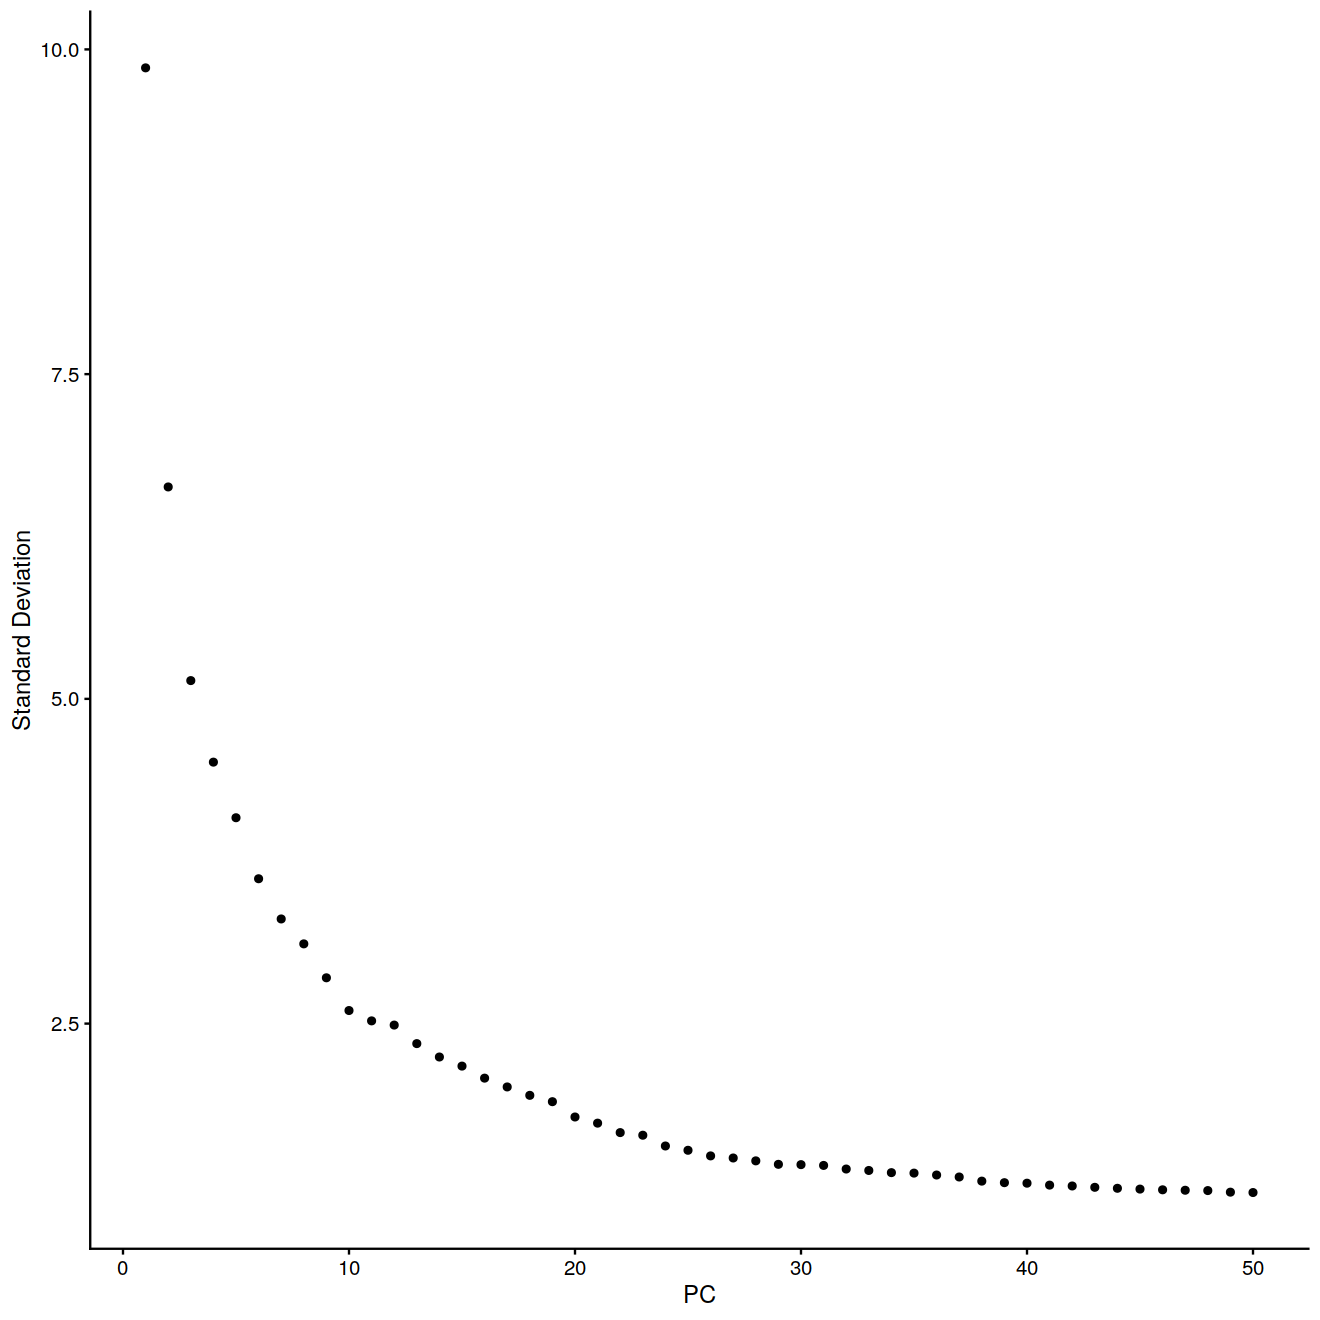

In [58]:
ElbowPlot(object = obj.integrated, ndims = 50)

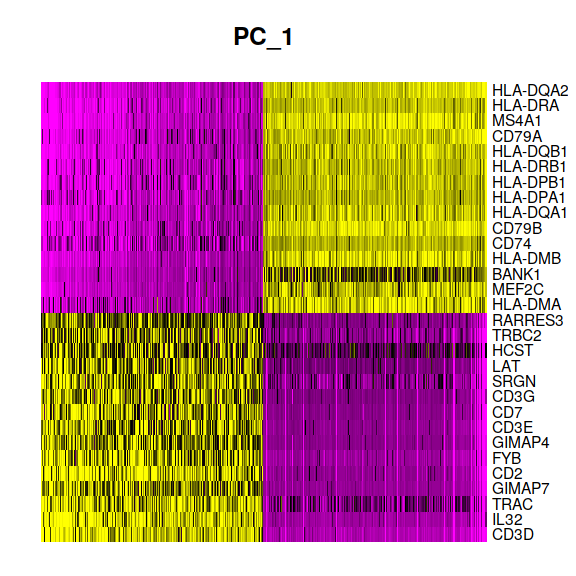

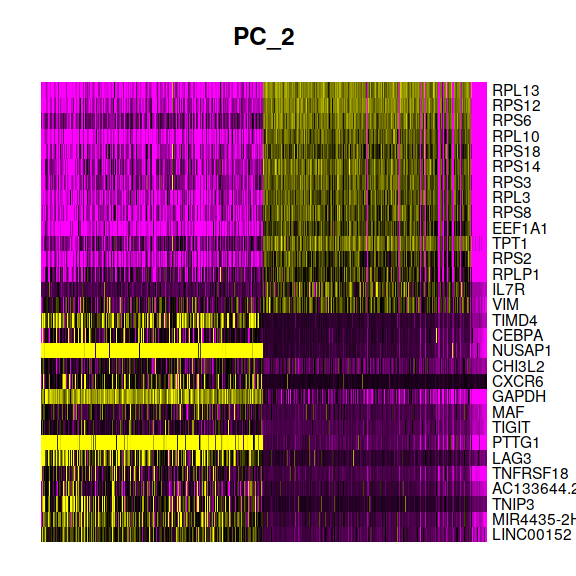

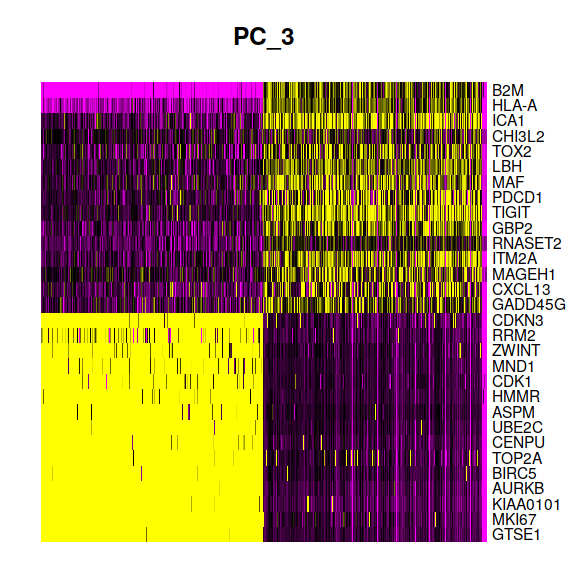

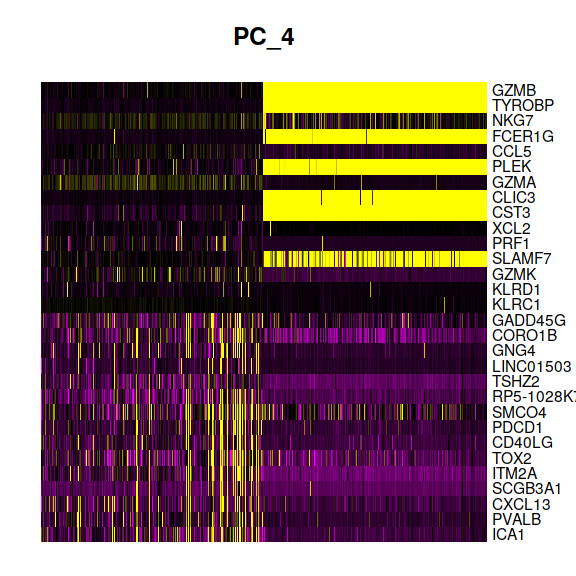

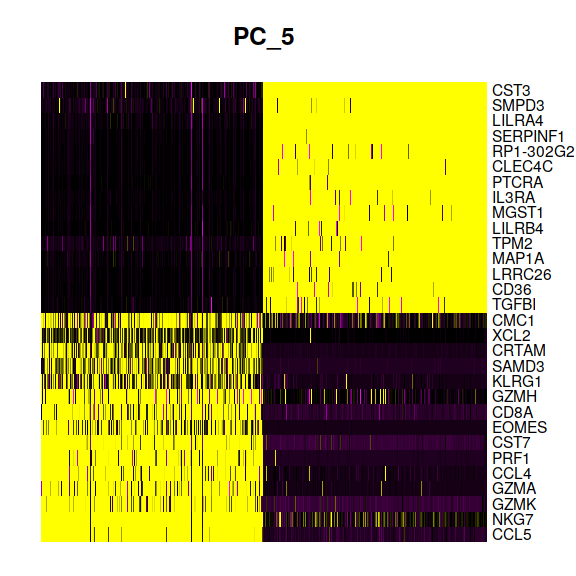

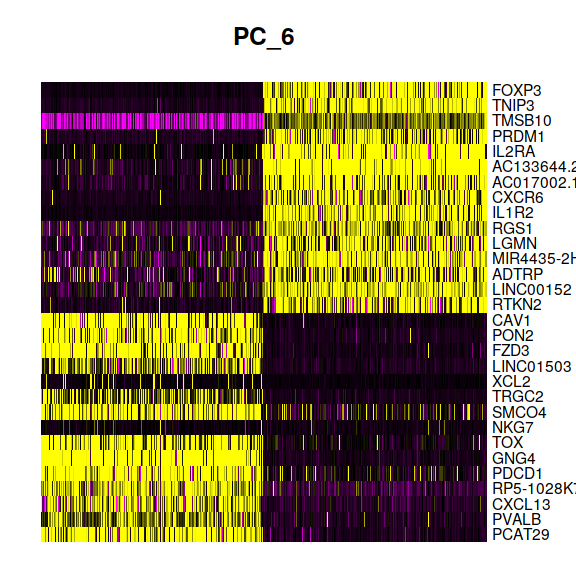

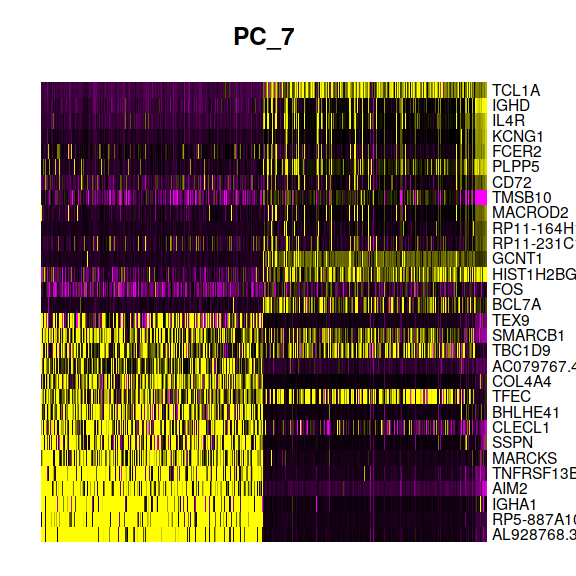

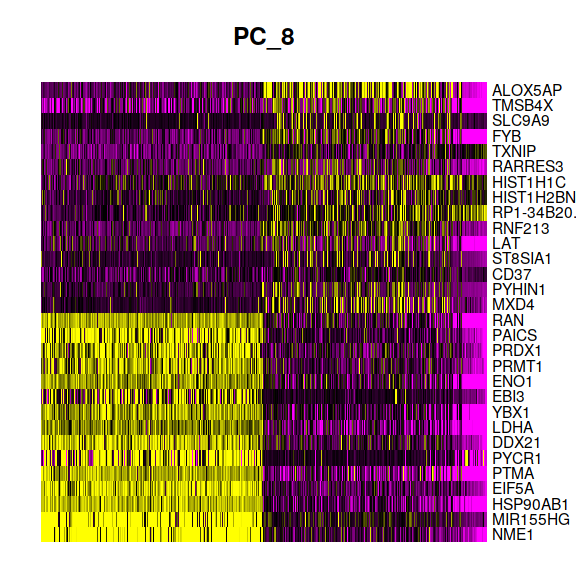

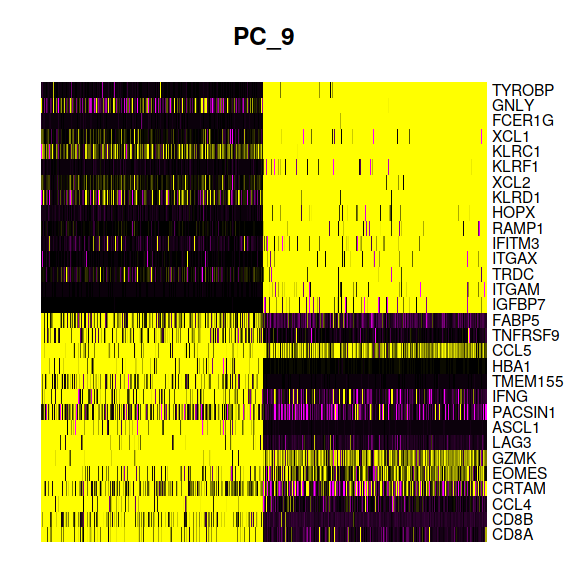

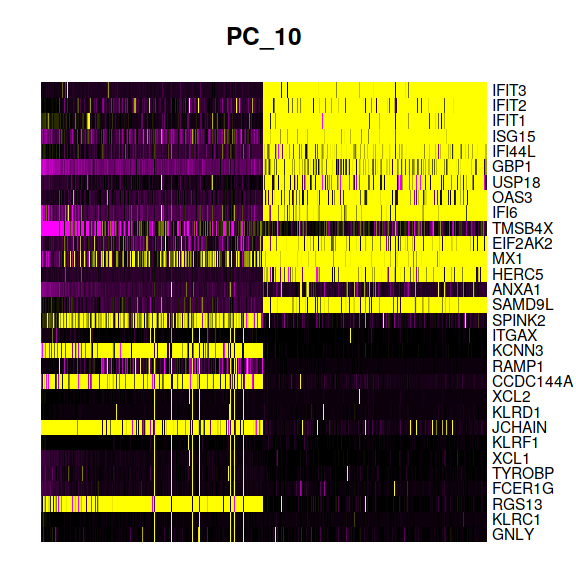

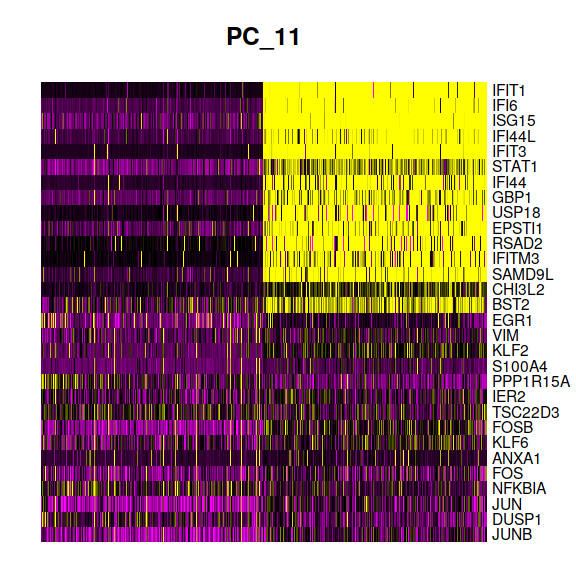

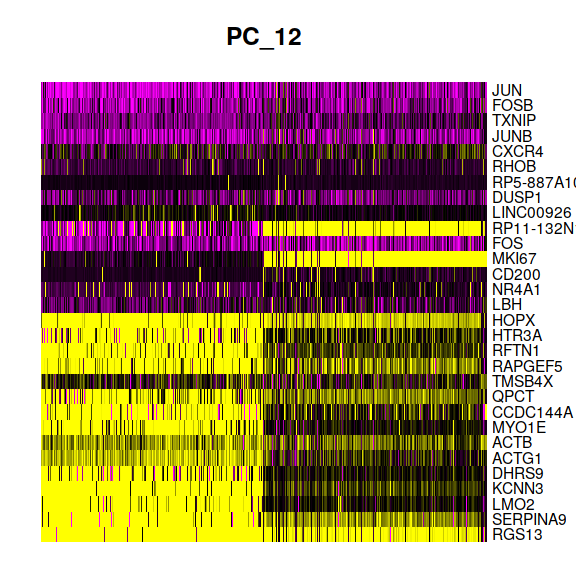

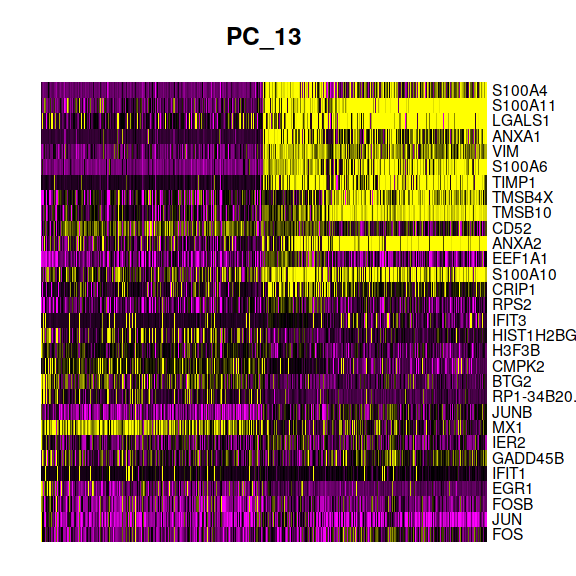

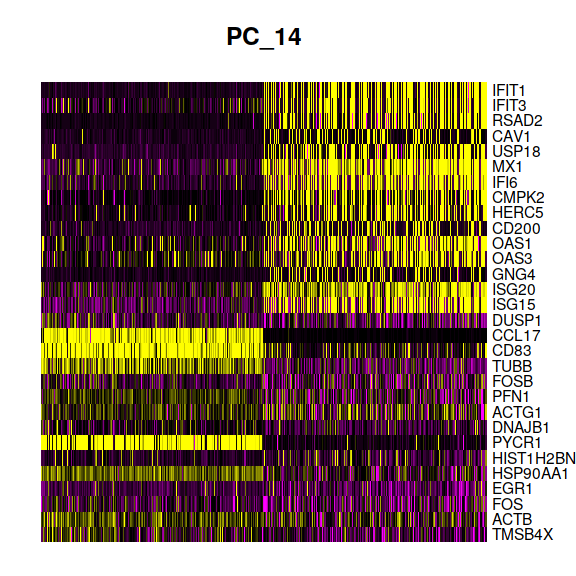

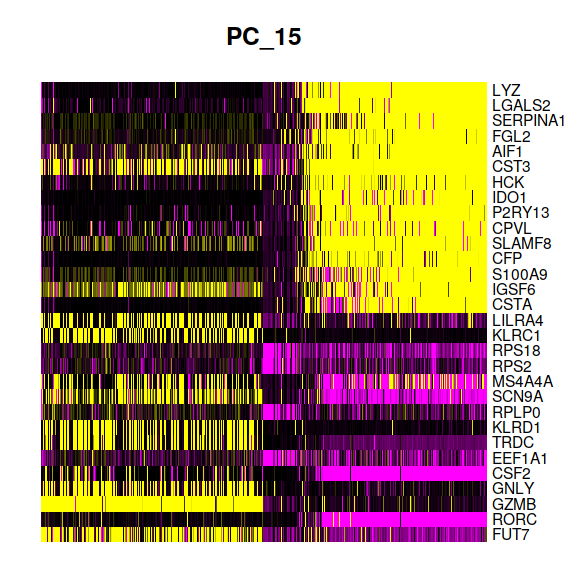

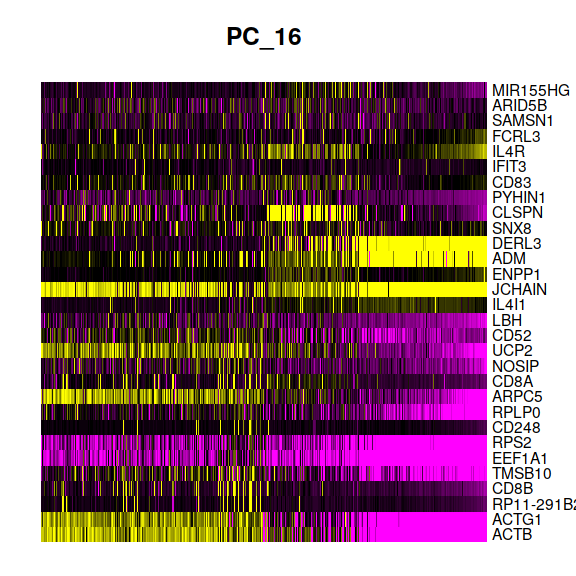

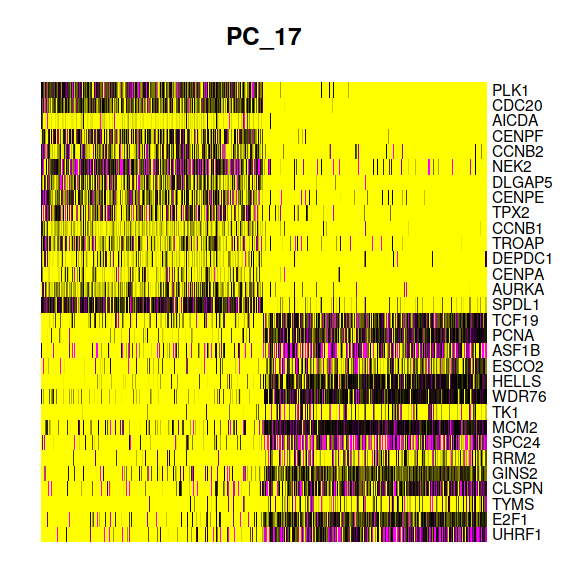

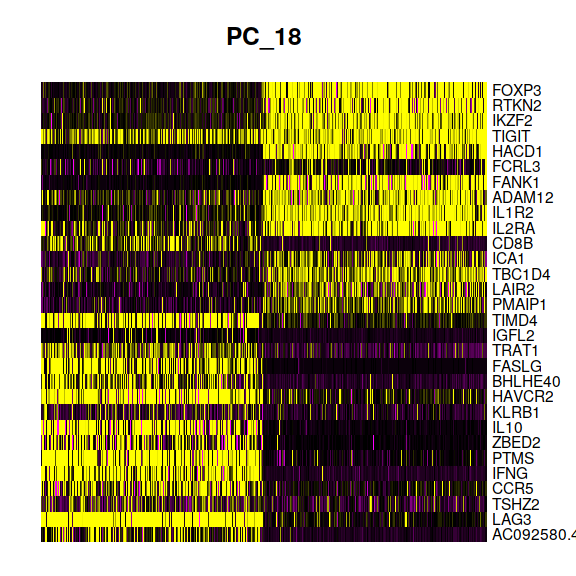

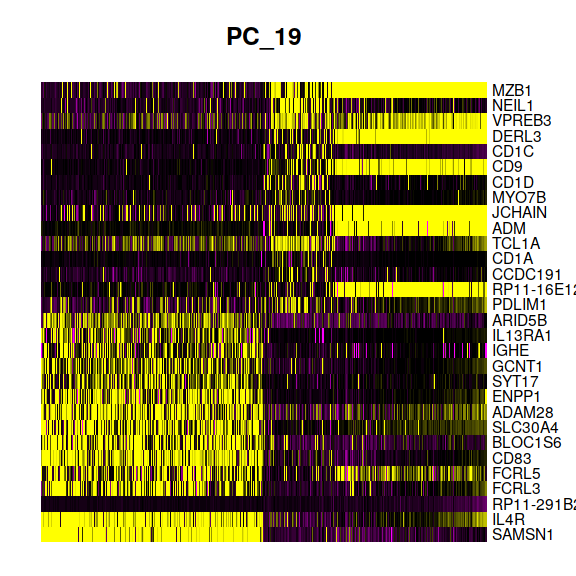

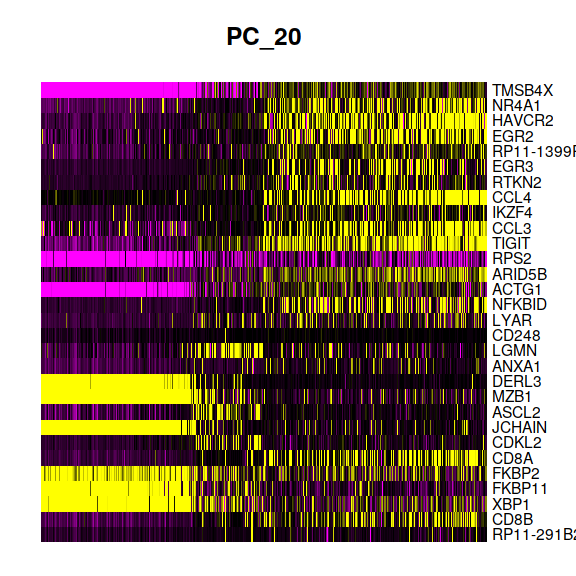

In [53]:
DimHeatmap(object = obj.integrated, dims = 1, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 2, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 3, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 4, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 5, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 6, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 7, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 8, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 9, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 10, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 11, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 12, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 13, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 14, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 15, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 16, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 17, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 18, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 19, cells = 500, balanced = TRUE)
DimHeatmap(object = obj.integrated, dims = 20, cells = 500, balanced = TRUE)

# Cluster the cells

In [44]:
dim_number <- 30

In [45]:
obj.integrated <- FindNeighbors(object = obj.integrated, dims = 1:dim_number)

Computing nearest neighbor graph

Computing SNN



In [46]:
res <- 0.8

In [47]:
obj.integrated <- FindClusters(object = obj.integrated, resolution = res)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 127686
Number of edges: 5084455

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8954
Number of communities: 27
Elapsed time: 69 seconds


1 singletons identified. 26 final clusters.



# Run Non-linear dimensional reduction (UMAP)

In [48]:
obj.integrated <- RunUMAP(obj.integrated, dims = 1:dim_number)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
08:55:22 UMAP embedding parameters a = 0.9922 b = 1.112

08:55:22 Read 127686 rows and found 30 numeric columns

08:55:22 Using Annoy for neighbor search, n_neighbors = 30

08:55:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

08:55:40 Writing NN index file to temp file /tmp/RtmphzhBFr/file32d465608bb7

08:55:40 Searching Annoy index using 1 thread, search_k = 3000

08:56:39 Annoy recall = 100%

08:56:40 Commencing smooth kNN distance calibration using 1 thread

08:56:51 Initializing f

In [49]:
obj <- obj.integrated

## Sample Effect, Chip, Old clusters

In [50]:
default_width <- 12

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



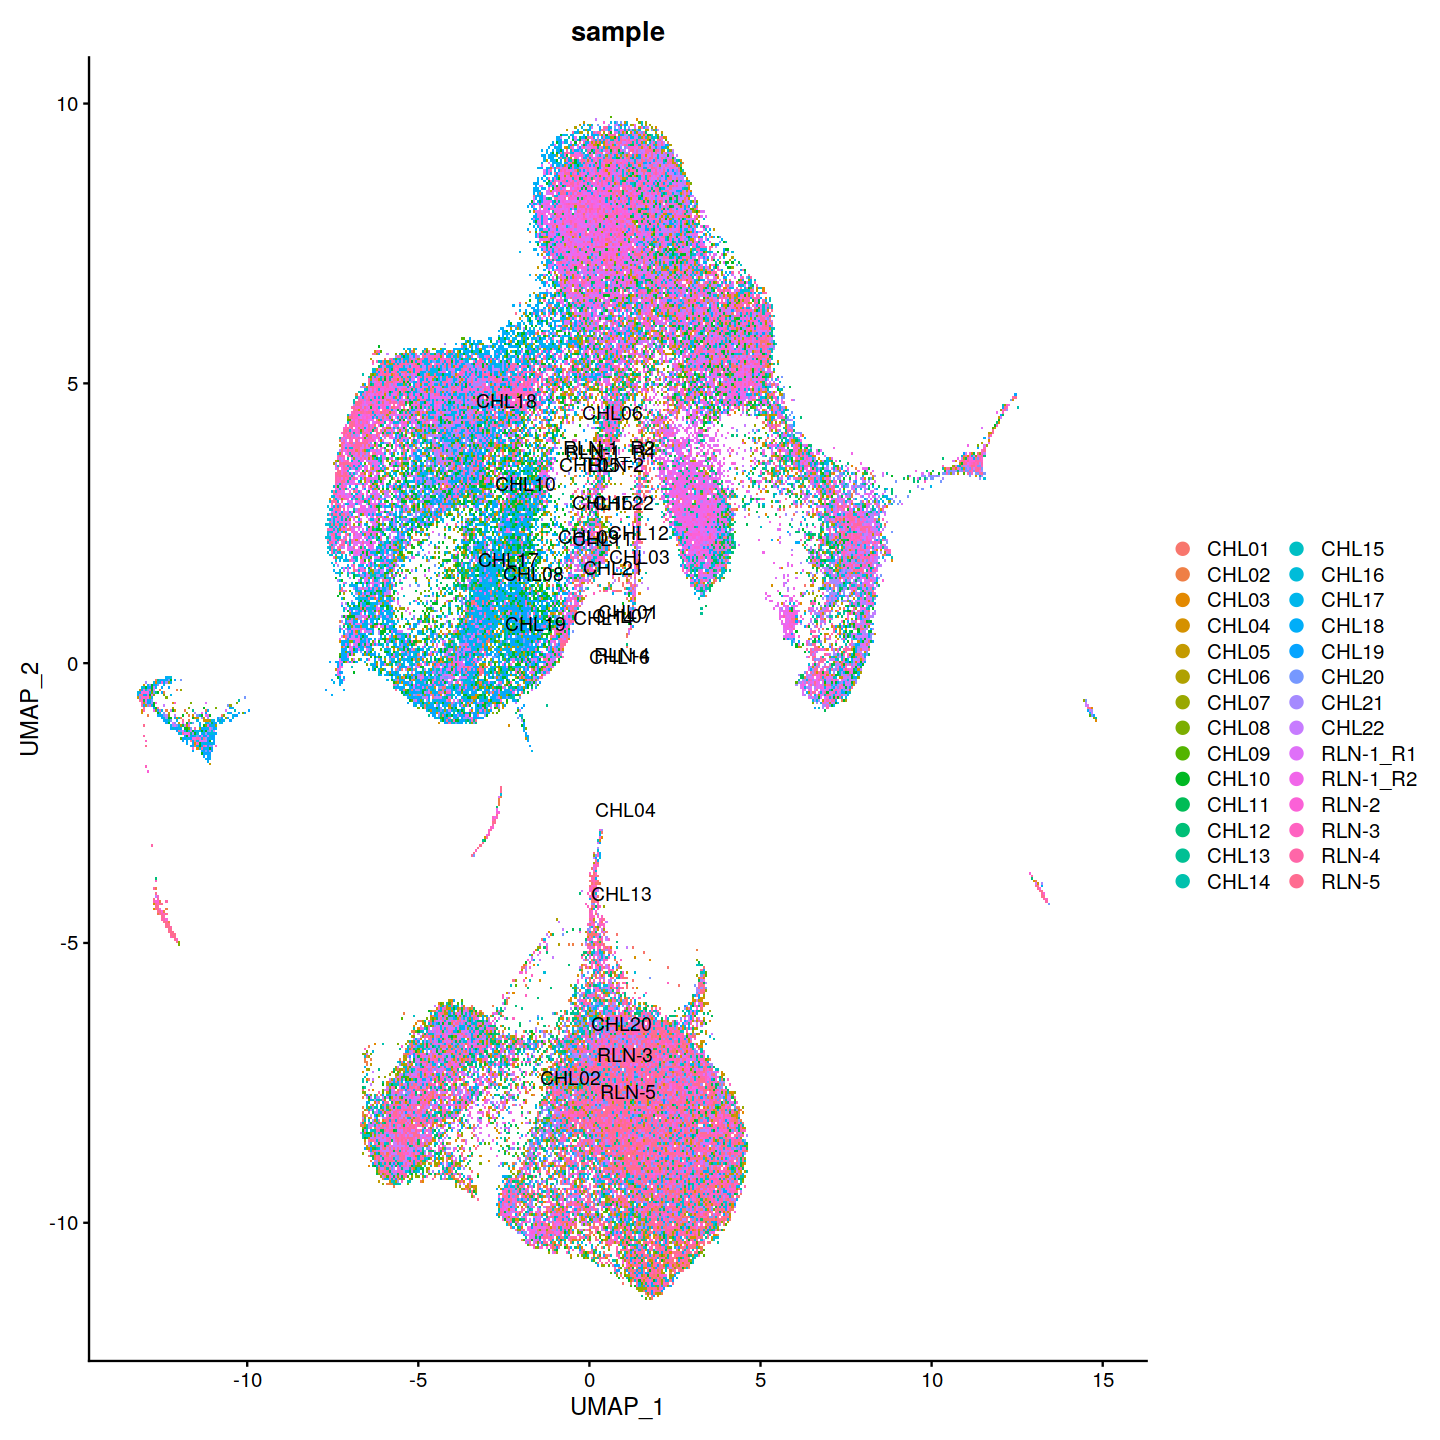

In [51]:
set_figsize(default_width, default_width)
fig(DimPlot(obj, group.by="sample", label = T), 
    "UMAP_Sample")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



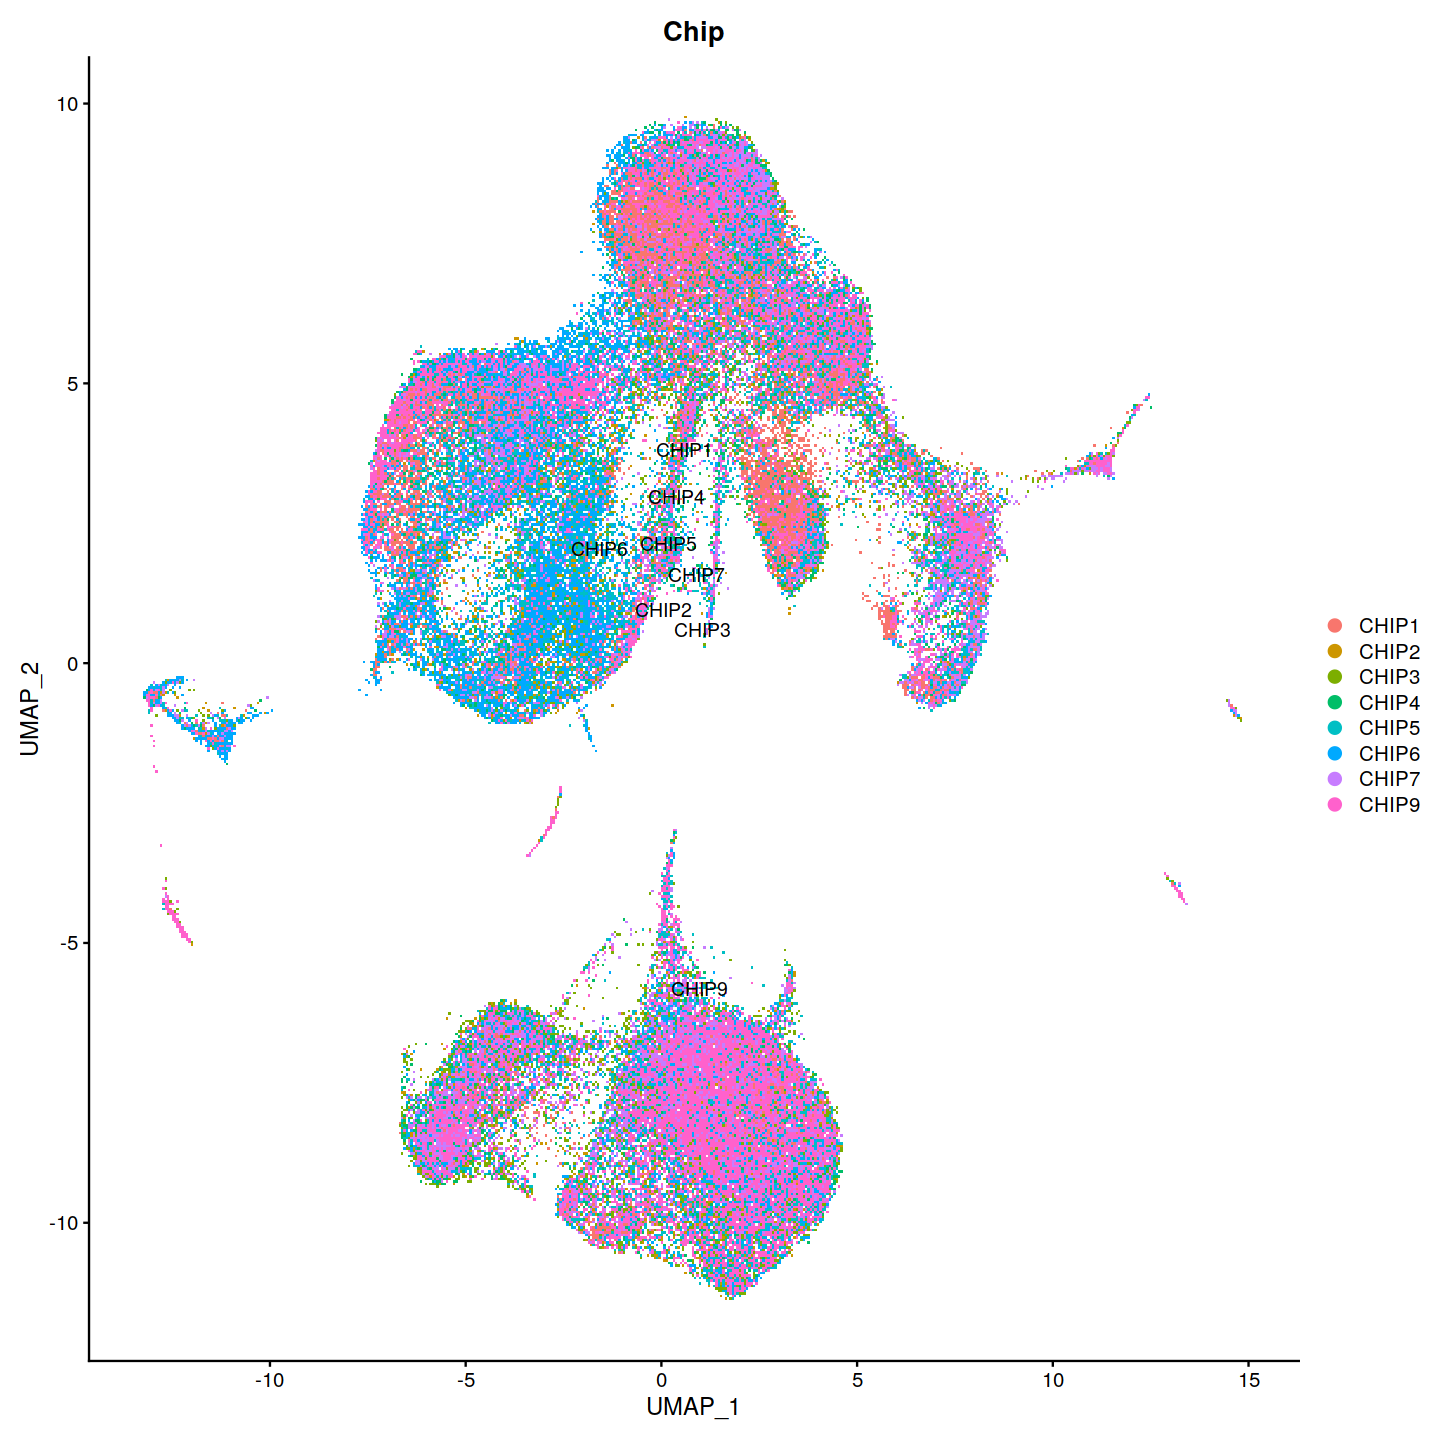

In [52]:
set_figsize(default_width, default_width)
fig(DimPlot(obj, group.by="Chip", label = T), 
    "UMAP_Chip")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



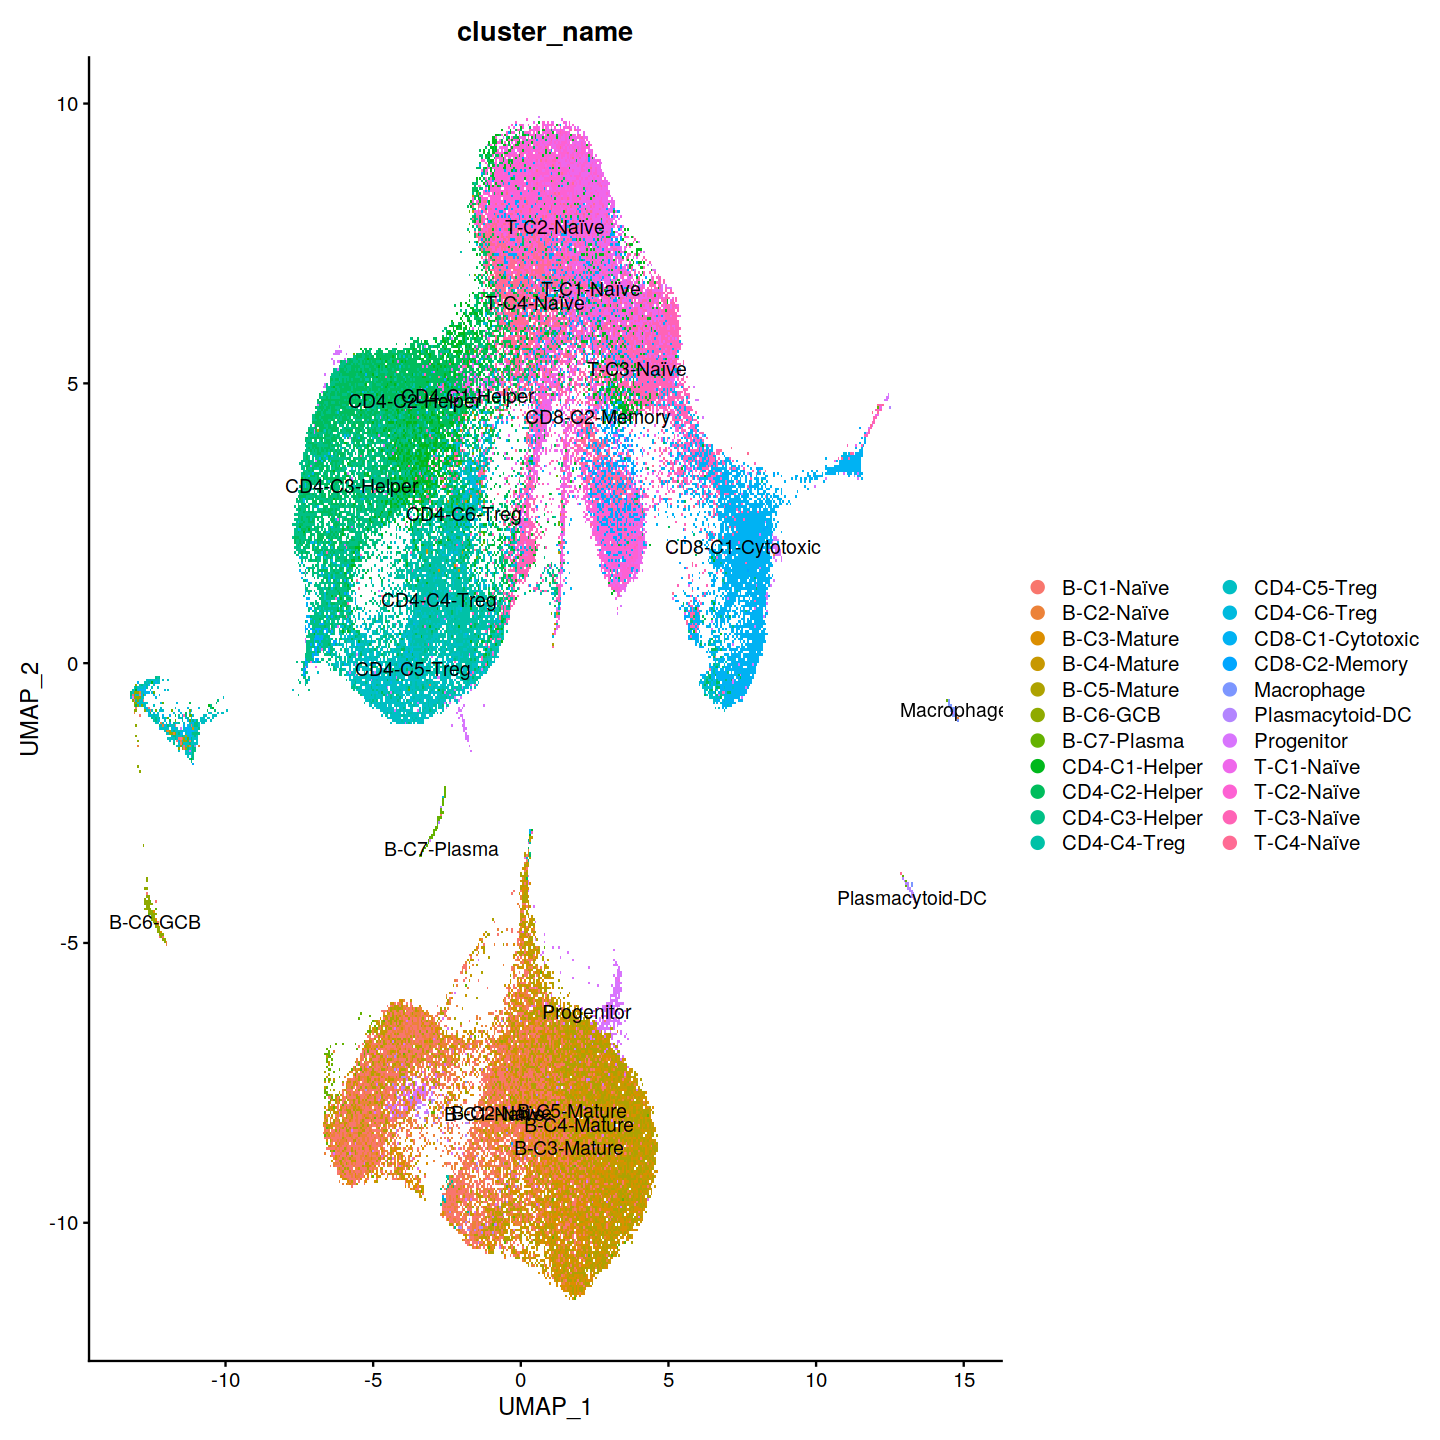

In [53]:
set_figsize(default_width, default_width)
fig(DimPlot(obj, group.by="cluster_name", label = T), 
    "UMAP_oldclusters")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



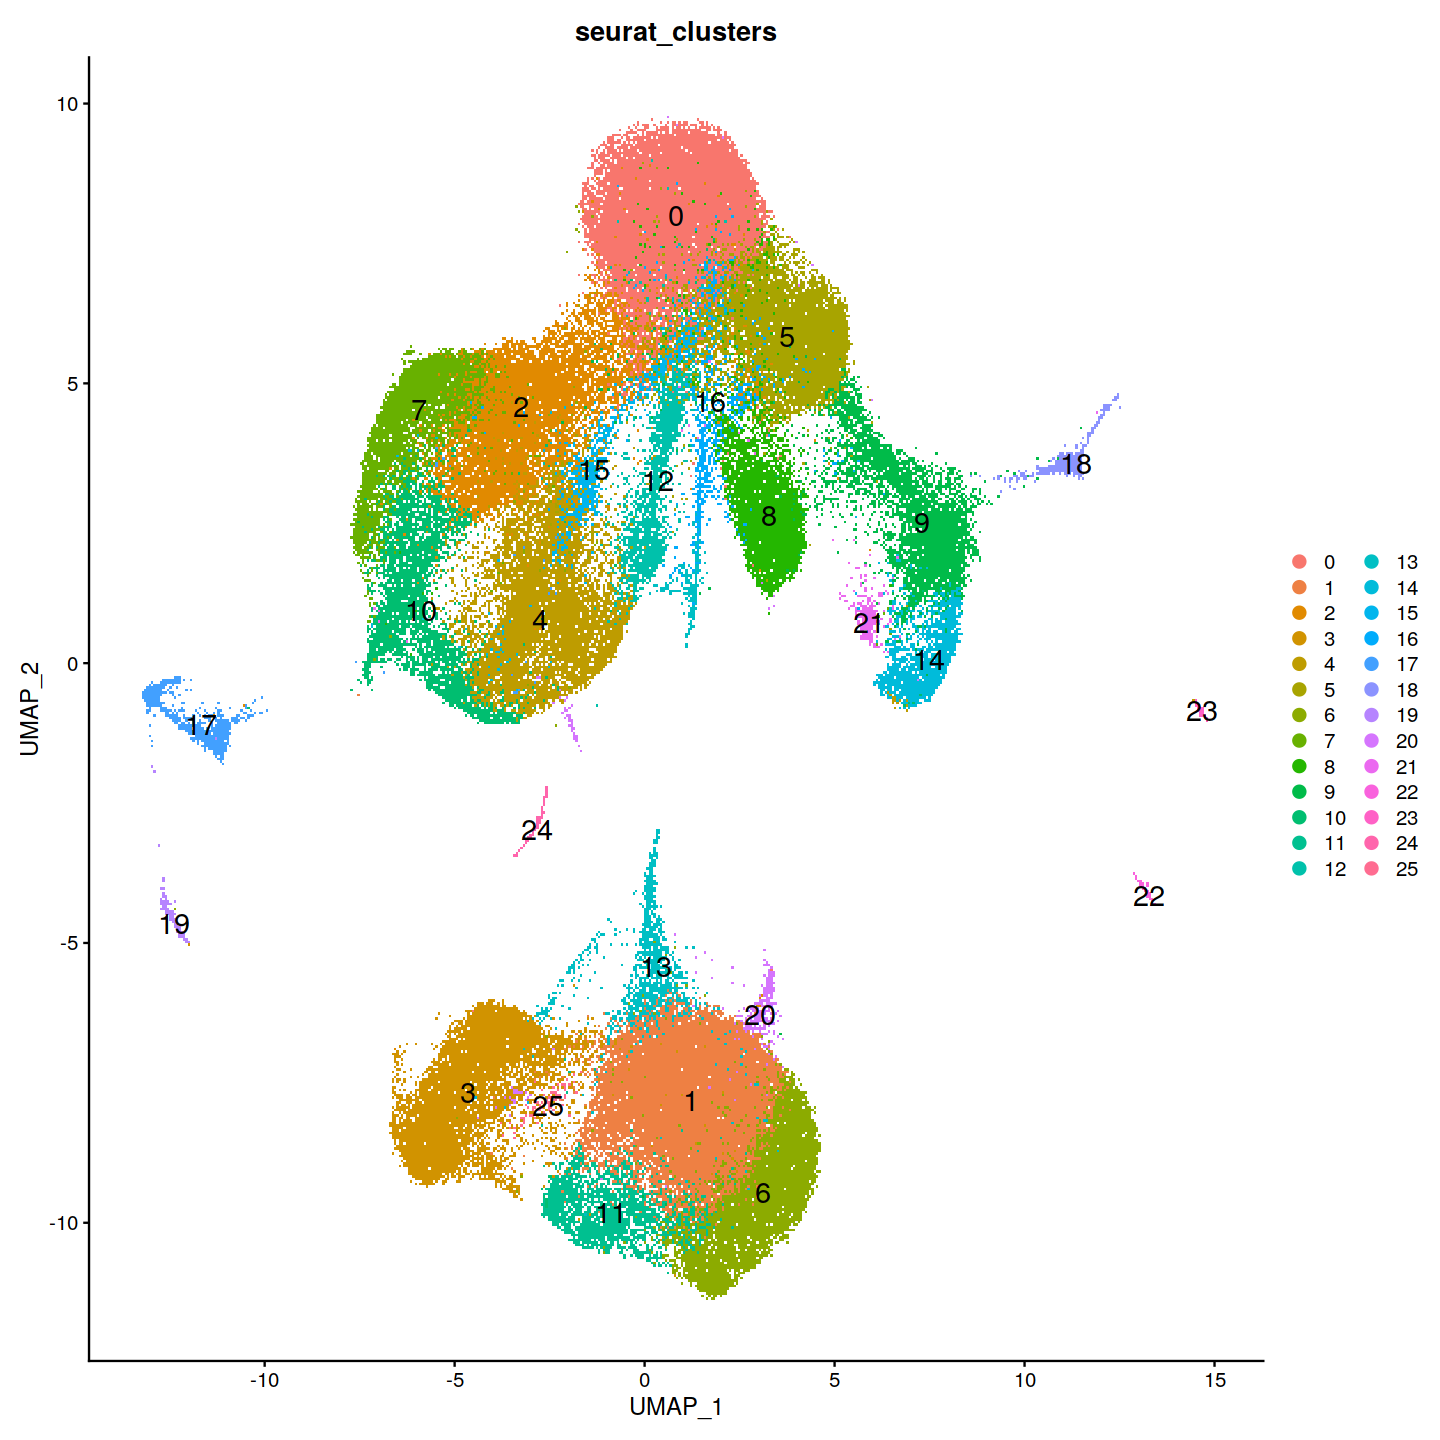

In [54]:
set_figsize(default_width,default_width)
fig(DimPlot(obj, reduction = "umap", label=TRUE, label.size=6, group.by="seurat_clusters"), 
    "Cluster_UMAP")

## Cell Cycle

In [1]:
obj <- CellCycleScoring(obj, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

ERROR: Error in CellCycleScoring(obj, s.features = s.genes, g2m.features = g2m.genes, : could not find function "CellCycleScoring"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



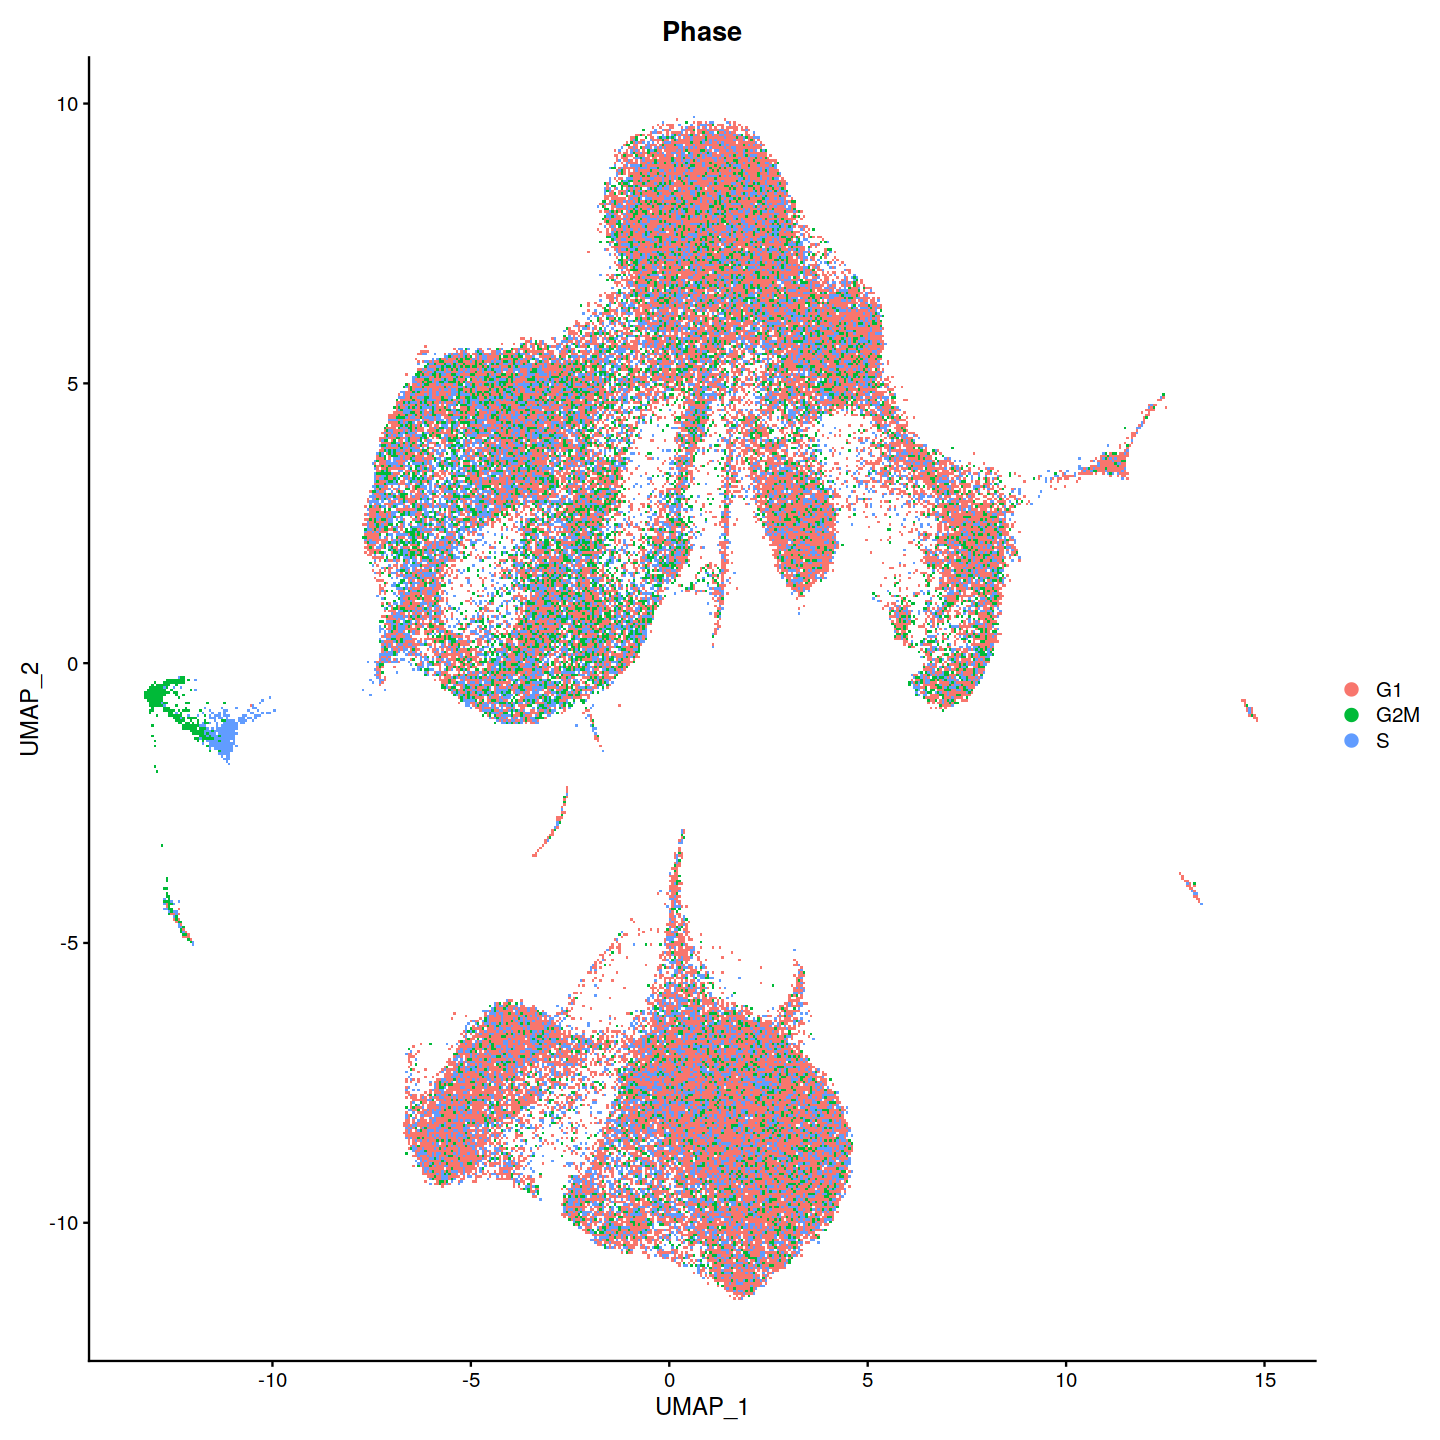

In [55]:
set_figsize(default_width, default_width)
fig(DimPlot(obj, group.by="Phase"), 
    "UMAP_Cellcycle")

## Cluster QC-Metrics

In [56]:
default_width <- 8

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



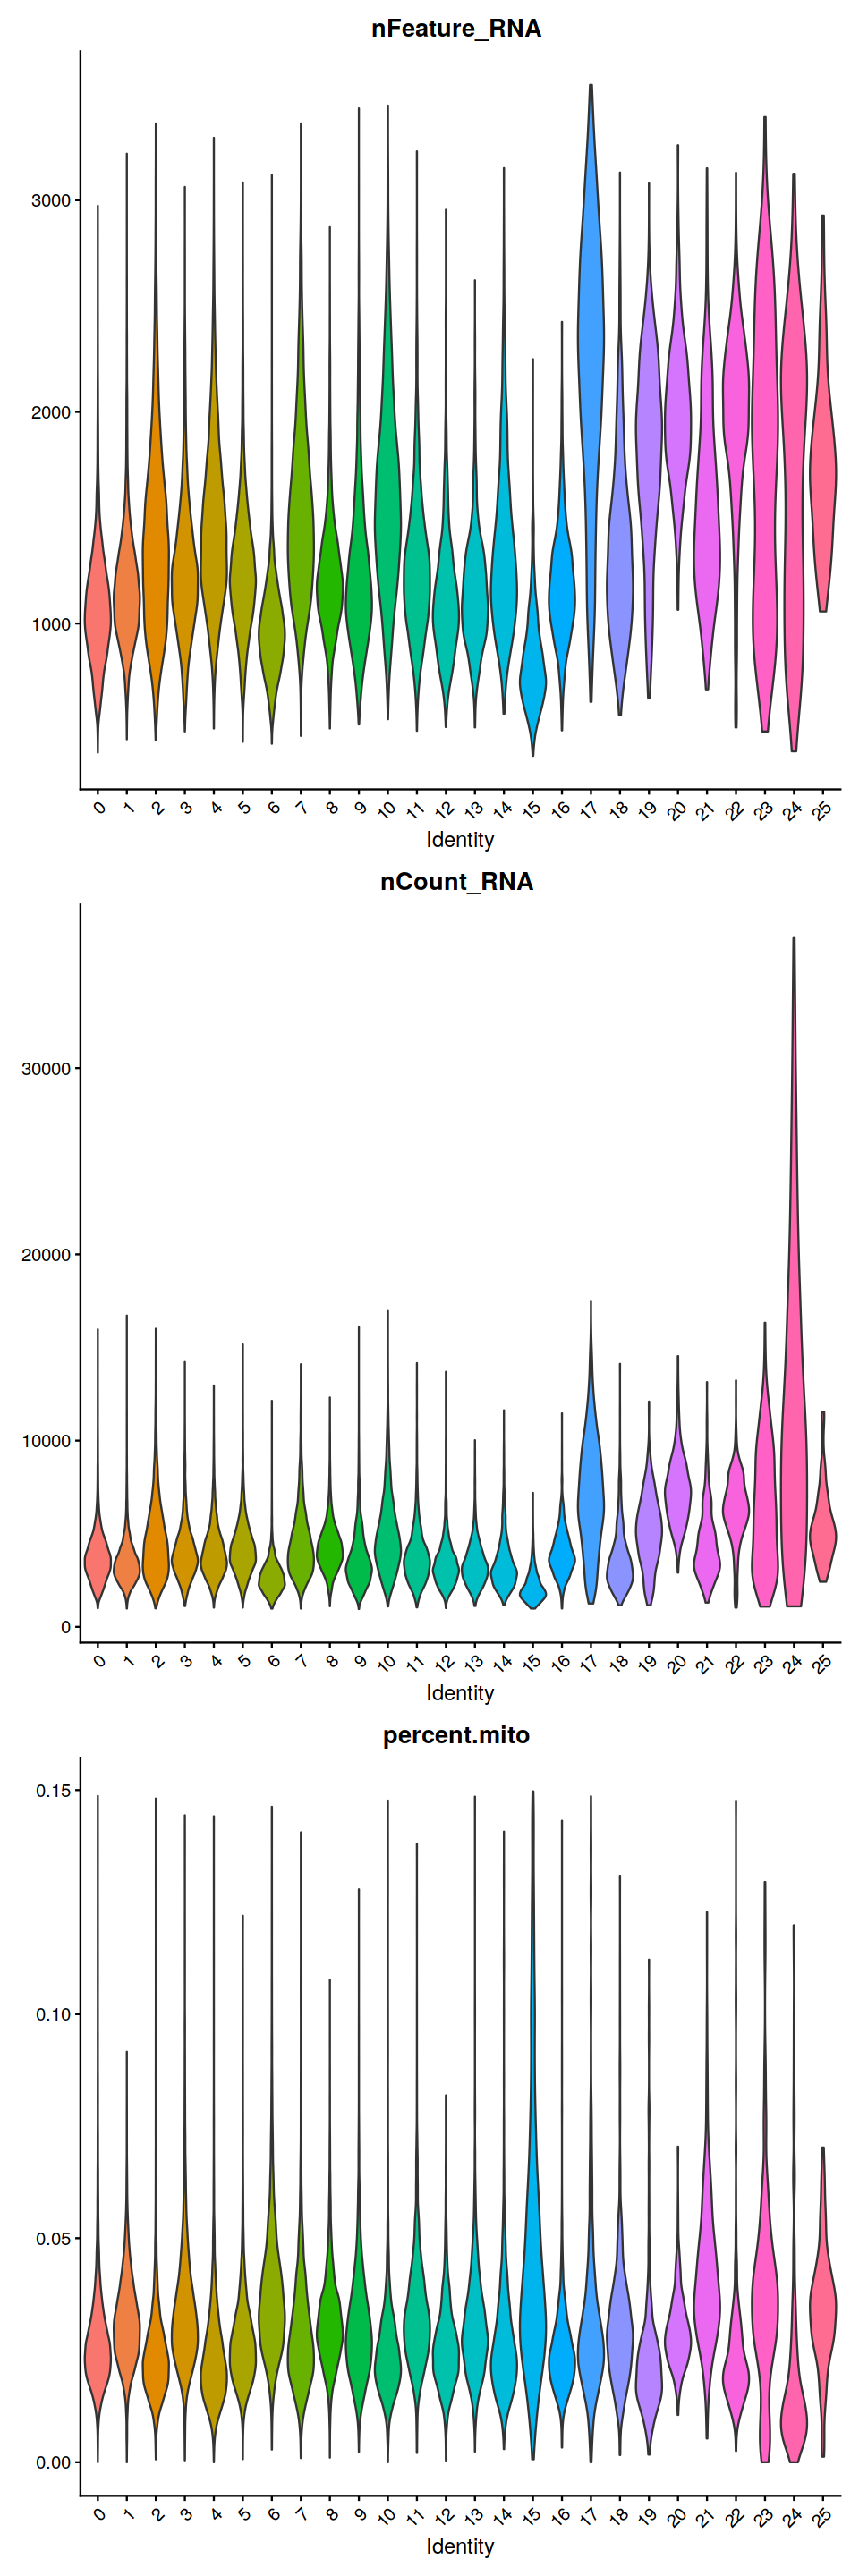

In [57]:
set_figsize(default_width,3*default_width)
fig(VlnPlot(obj, c("nFeature_RNA", "nCount_RNA", "percent.mito"), ncol=1, group.by="seurat_clusters", pt.size=0), 
    "Cluster_QC")

### Cluster Cell Cyle

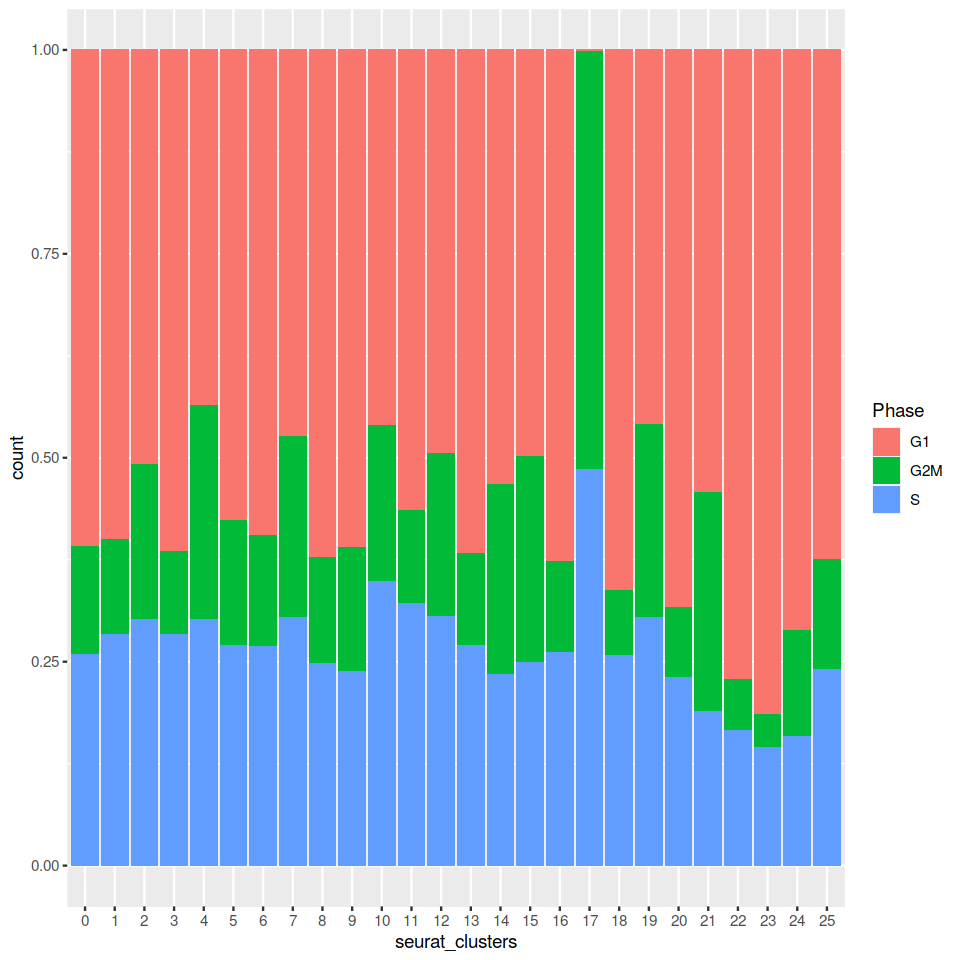

In [58]:
set_figsize(default_width, default_width)
ggplot(obj@meta.data, aes_string(x="seurat_clusters", fill="Phase")) +
    geom_bar(position="fill")

### Sample Proportions of Each Cluster

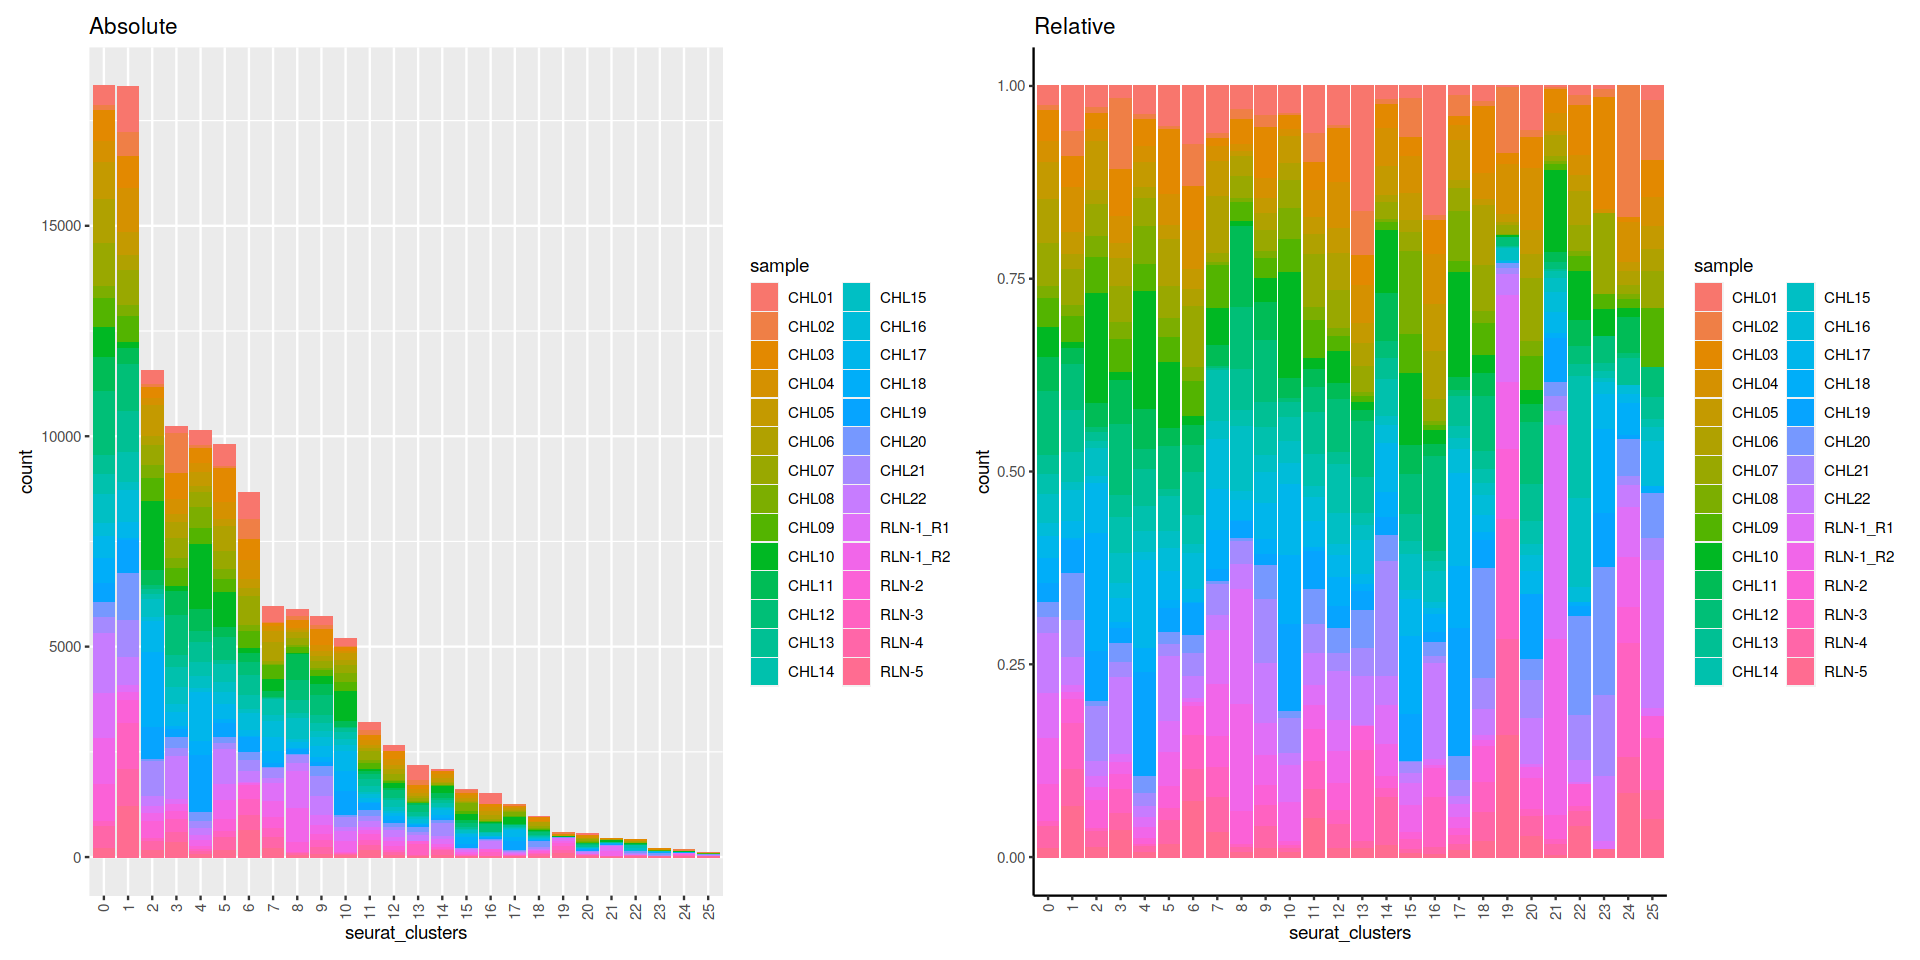

In [59]:
set_figsize(2*default_width, default_width)
fig(((ggplot(obj@meta.data, aes_string(x="seurat_clusters", fill="sample")) +
    geom_bar(position="stack") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))) +
    ggtitle("Absolute") +
(ggplot(obj@meta.data, aes_string(x="seurat_clusters", fill="sample")) +
    geom_bar(position="fill") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
         panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black")) +
    ggtitle("Relative"))), 
    "Cluster_Sample_Proportion")

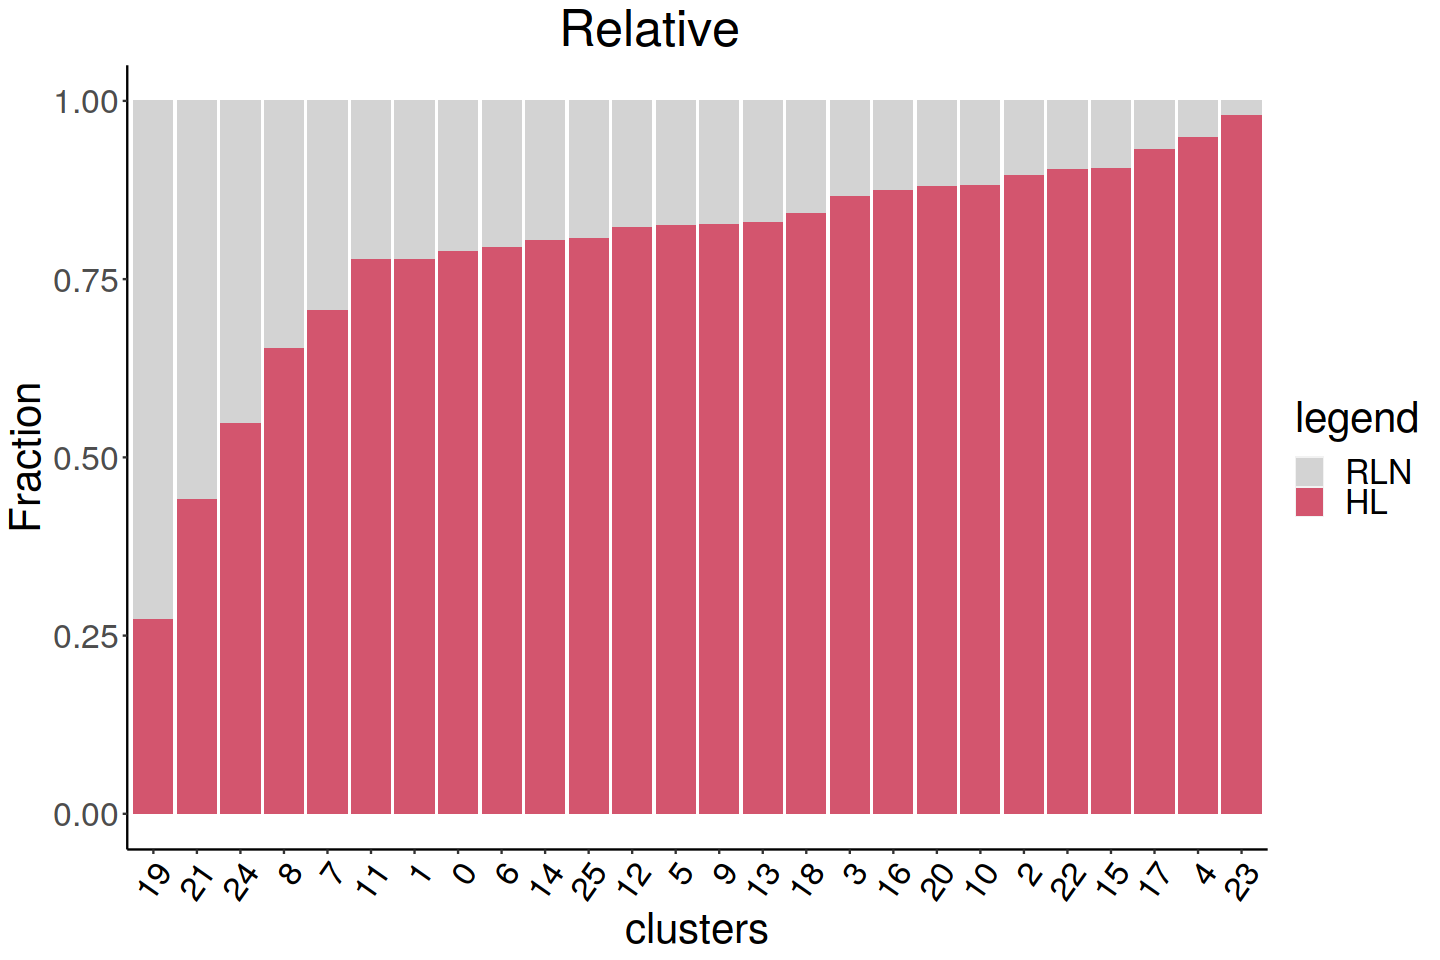

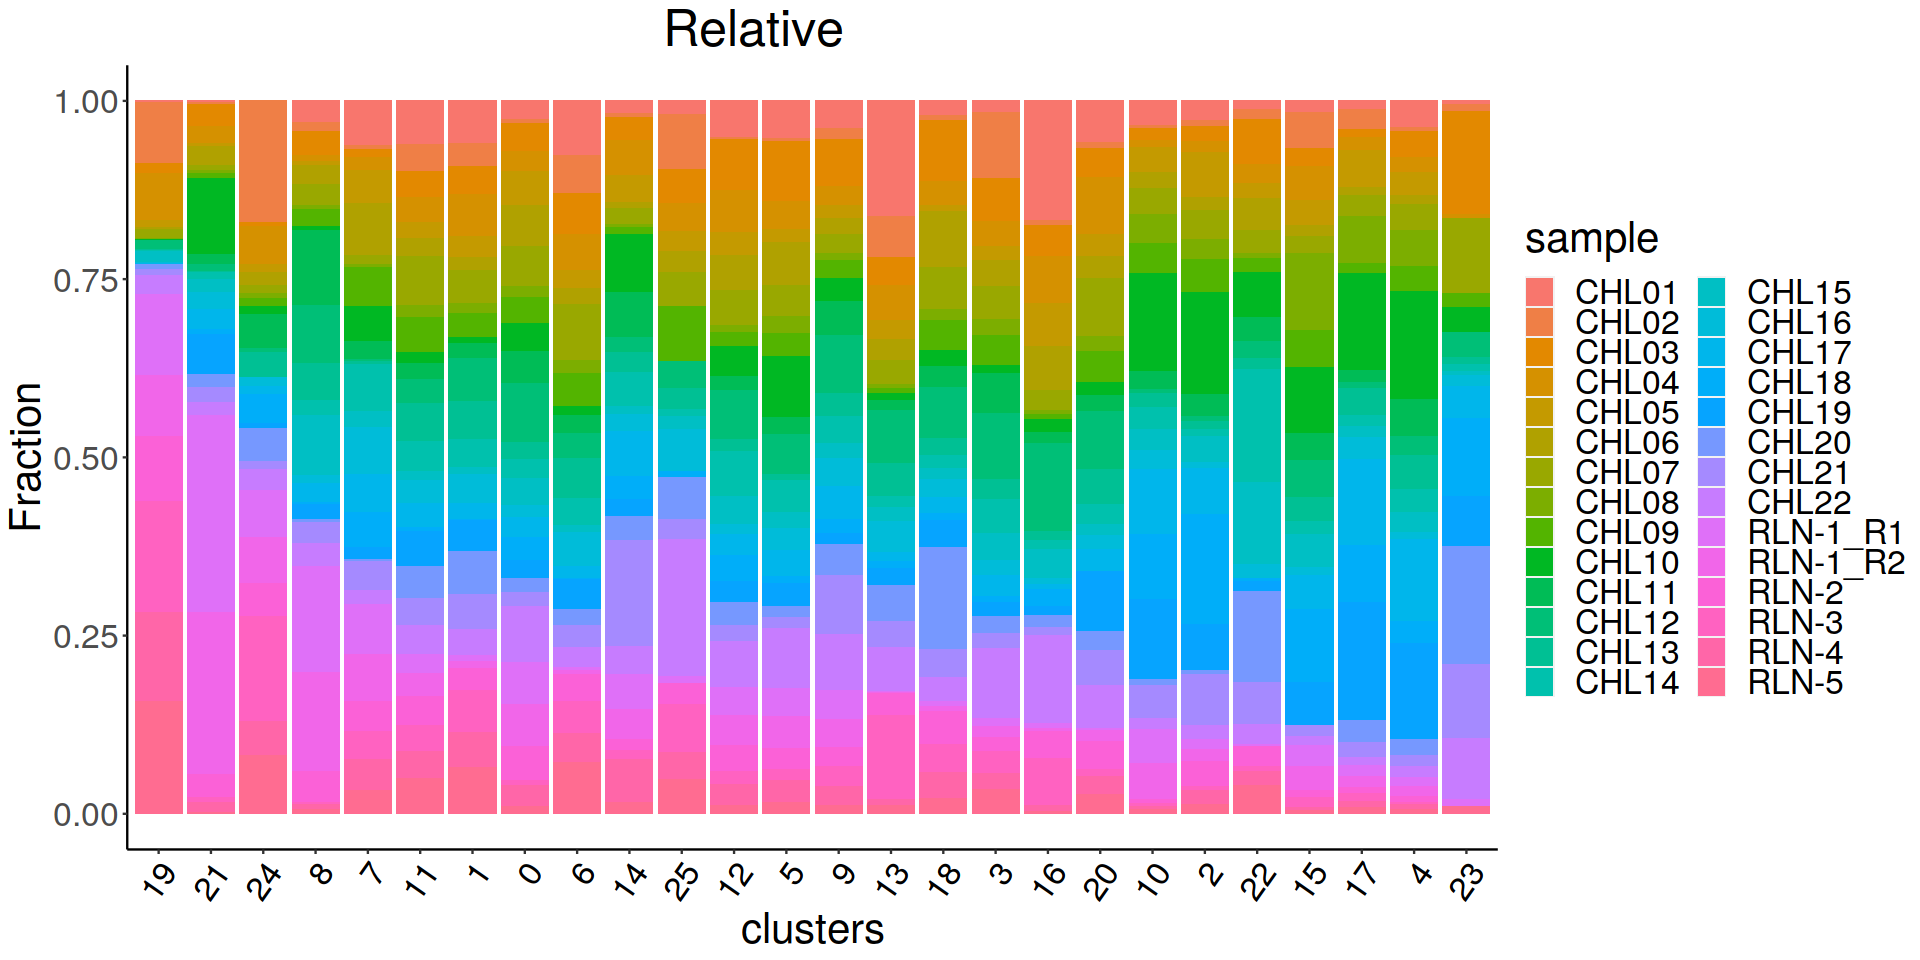

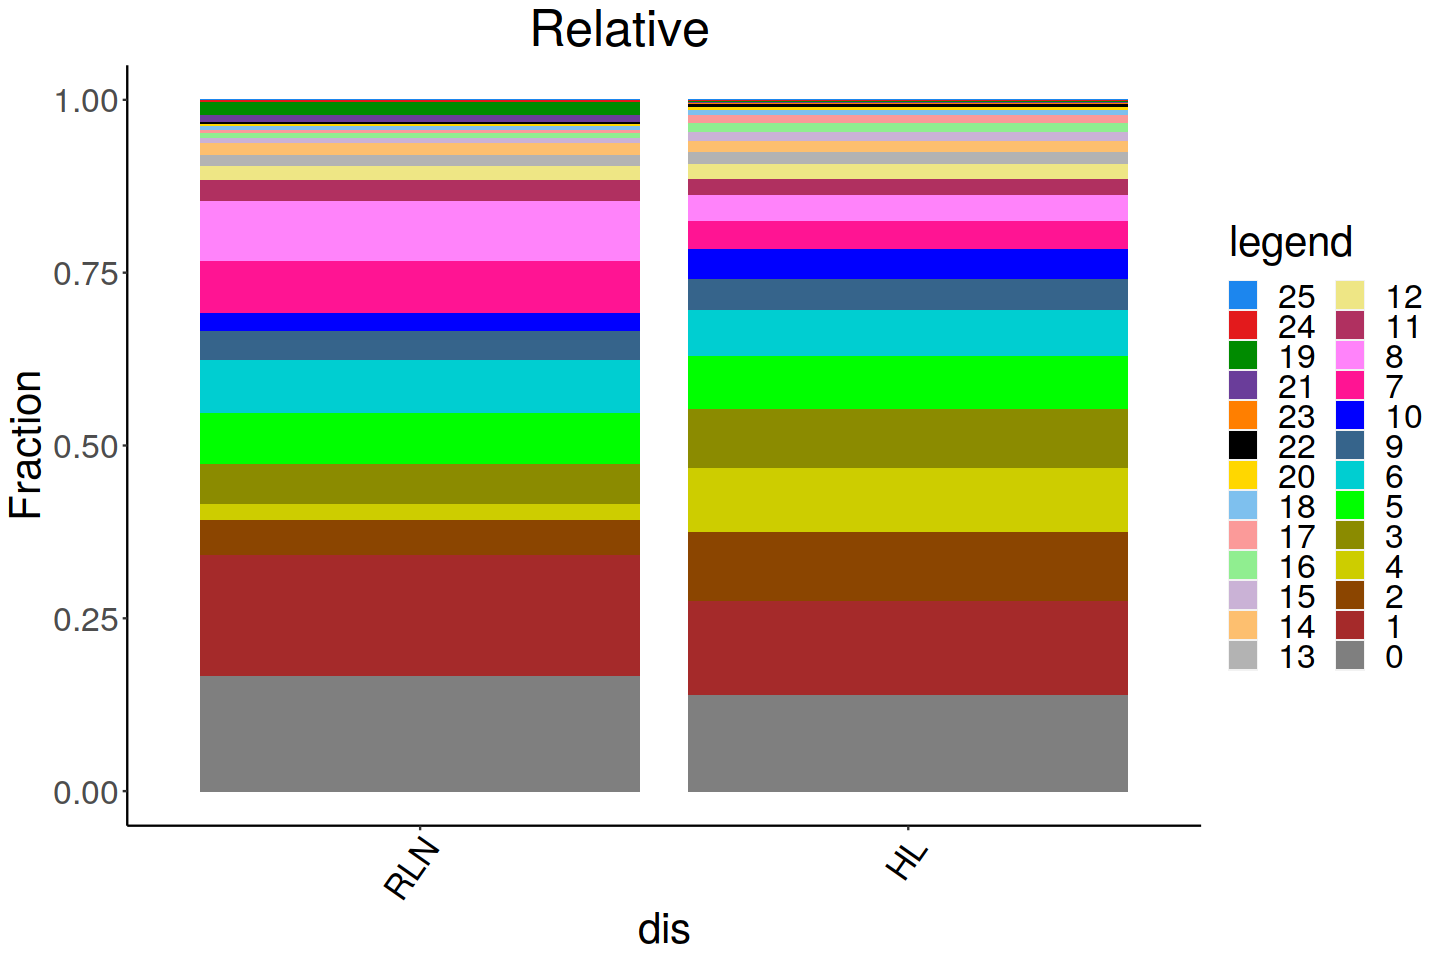

In [61]:
set_figsize(1.5*default_width, default_width)

df <- obj@meta.data
df$clusters <- df$seurat_clusters
clusters <- unique(df$clusters)
dis_state <- 'HL'
df$dis <- df$Type
df$dis <- factor(df$dis, levels = c('RLN', 'HL'))

#determine where are the most cells from HL
order_df <- data.frame(matrix(NA, ncol = 2, nrow = length(clusters)))
colnames(order_df) <- c('cluster', 'dis')
order_df$cluster <- clusters
for(i in 1:nrow(order_df)){
    order_df$dis[i] <- nrow(filter(df, dis == dis_state & clusters == order_df$cluster[i])) / nrow(filter(df, clusters == order_df$cluster[i]))
}

order_df <- order_df[order(order_df$dis), ]
order_list <- order_df$cluster

#order the clusters in the df 
df$clusters <- factor(df$clusters, levels = order_list)

#plot the type of disease state
ggplot(df, aes_string(x="clusters", fill="dis")) +
    geom_bar(position="fill") + 
    theme(
        plot.title = element_text(hjust = 0.45),
        text = element_text(size=25),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"),
        axis.text.x = element_text(angle = 55, vjust = 1, hjust=1, colour = 'black')) +
        scale_fill_manual('legend', values = c('lightgrey', '#D3556E'))+ ylab('Fraction')+
    ggtitle("Relative")

set_figsize(2*default_width, default_width)




#plot per patient
#determine colors


ggplot(df, aes_string(x="clusters", fill="sample")) +
    geom_bar(position="fill") + 
    theme(
        plot.title = element_text(hjust = 0.45),
        text = element_text(size=25),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"),
        axis.text.x = element_text(angle = 55, vjust = 1, hjust=1, colour = 'black')) +
        ylab('Fraction') +
    ggtitle("Relative")








#plot per disease state
set_figsize(1.5*default_width, default_width)

#determine the order of clusters by fraction within the disease state
#determine where are the most cells from HL
order_df <- data.frame(matrix(NA, ncol = 2, nrow = length(clusters)))
colnames(order_df) <- c('cluster', 'dis')
order_df$cluster <- clusters
for(i in 1:nrow(order_df)){
    order_df$dis[i] <- nrow(filter(df, dis == dis_state & clusters == order_df$cluster[i])) / nrow(filter(df, dis == dis_state))
}

order_df <- order_df[order(order_df$dis), ]
order_list <- order_df$cluster

#order the clusters in the df 
df$clusters <- factor(df$clusters, levels = order_list)

#determine colors
c25 <- c(
  "dodgerblue2", "#E31A1C", # red
  "green4",
  "#6A3D9A", # purple
  "#FF7F00", # orange
  "black", "gold1",
  "skyblue2", "#FB9A99", # lt pink
  "palegreen2",
  "#CAB2D6", # lt purple
  "#FDBF6F", # lt orange
  "gray70", "khaki2",
  "maroon", "orchid1", "deeppink1", "blue1", "steelblue4",
  "darkturquoise", "green1", "yellow4", "yellow3",
  "darkorange4", "brown"
)
cols <- c25[1:length(clusters)]



ggplot(df, aes_string(x="dis", fill="clusters")) +
    geom_bar(position="fill") + 
    theme(
        plot.title = element_text(hjust = 0.45),
        text = element_text(size=25),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"),
        axis.text.x = element_text(angle = 55, vjust = 1, hjust=1, colour = 'black')) +
        ylab('Fraction')+ scale_fill_manual('legend', values = cols)+
    ggtitle("Relative")

### Cluster Size

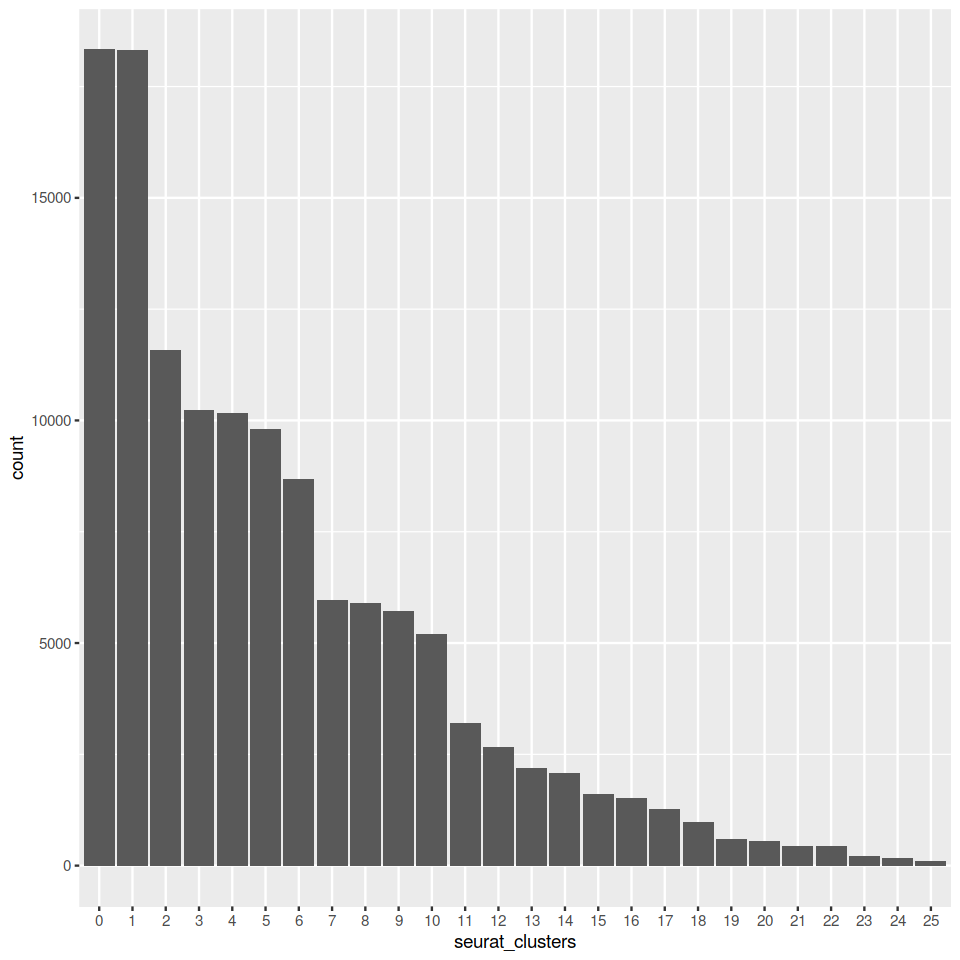

In [ ]:
set_figsize(default_width, default_width)
ggplot(obj@meta.data, aes_string(x="seurat_clusters")) + geom_bar()

In [67]:
saveRDS(obj, file = './rpca_integrated.rds')

In [17]:
obj <- readRDS(file = './rpca_integrated.rds')

In [83]:
obj

An object of class Seurat 
36194 features across 127686 samples within 2 assays 
Active assay: RNA (33694 features, 0 variable features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

# Find Cluster Markers

## Find Markers

In [68]:
features_find <- rownames(obj)
markers.remove <- grep(pattern = c("^TRAV|^TRBV|^TRGV|^TRDV|^IGKV|^IGLV|^IGHV|^IGHG|^IGK"), x = rownames(obj), value = TRUE)
features_find <- features_find[!(features_find%in%markers.remove)]

markers <- FindAllMarkers(obj, 
                          min.pct = 0.1, 
                          logfc.threshold = 0.2, 
                          only.pos = TRUE, 
                          verbose = verbose,
                          features = features_find)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25



In [69]:
write.csv(markers, file = './first_markers_unsorted_rpca.csv')

In [20]:
markers <- read.csv(file = './first_markers_unsorted_rpca.csv', row.names = 1)

Sort the markers:

In [70]:
top_number <- 100
sorted.markers <- markers %>% 
                    group_by(cluster) %>% 
                    arrange(cluster, desc(avg_log2FC)) %>% 
                    slice_head(n=top_number)
sorted.markers <- sorted.markers[sorted.markers$p_val_adj < 0.05, ]

In [71]:
sorted.markers.anno <- sorted.markers

## Annotate Markers

In [72]:
library(annotables, quietly=TRUE)

In [73]:
ref <- grch38[c('symbol', 'description', 'biotype')]
ref <- distinct(ref, symbol, .keep_all=T)
sorted.markers.anno <- left_join(sorted.markers, ref, by=c('gene'='symbol'))

In [74]:
write.csv(sorted.markers.anno, file = './first_markers_annotated_rpca.csv')

## Marker Heatmap and Dotplot

Centering and scaling data matrix

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



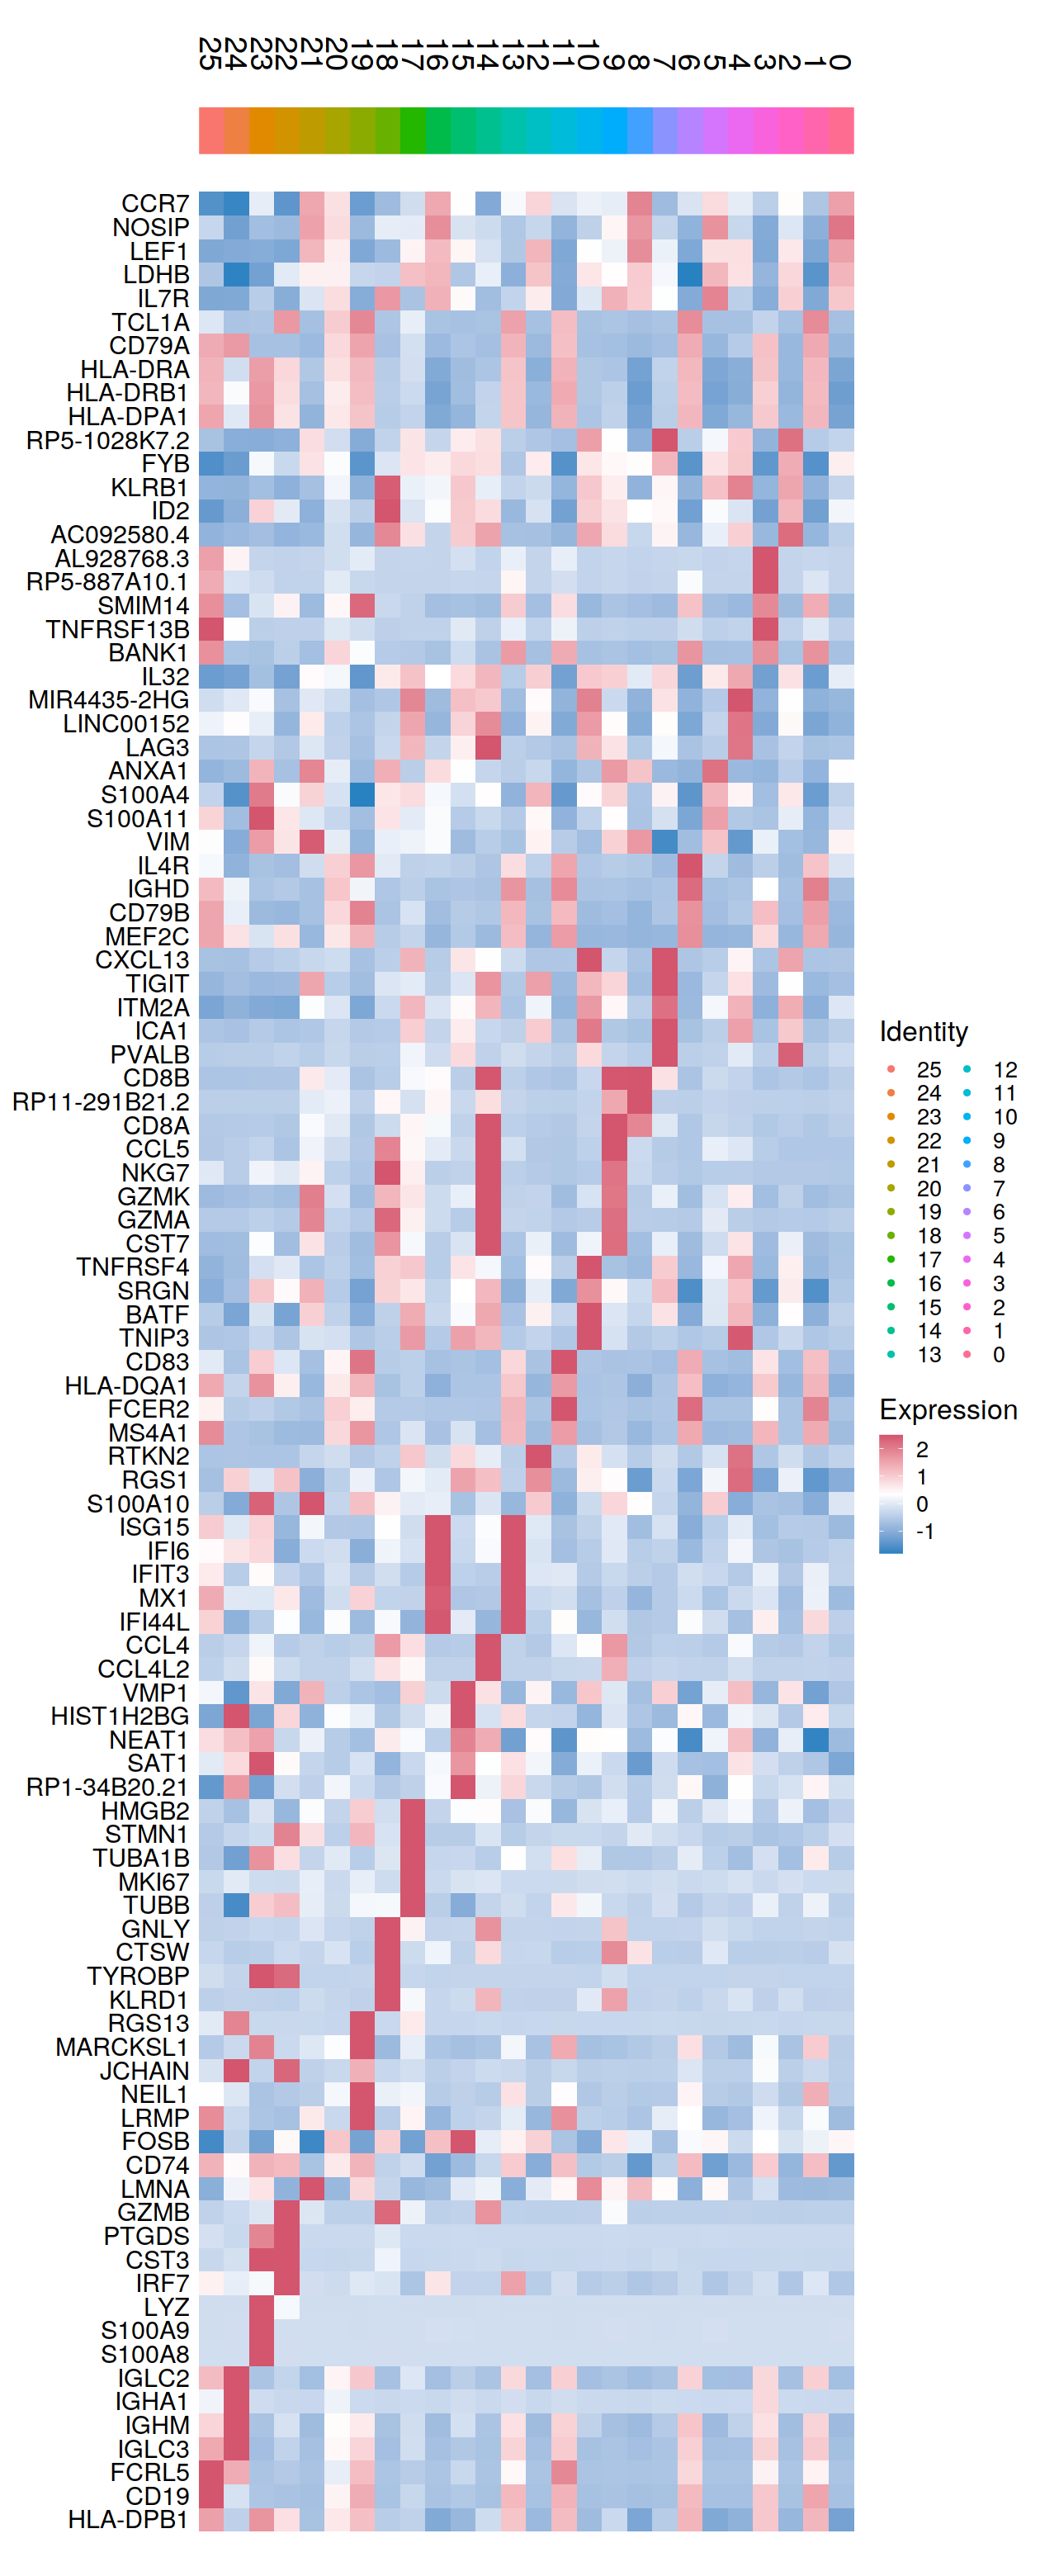

In [75]:
set_figsize(1.5*default_width,1.5*default_width)

#determine the number of genes to plot
top_number <- 5
markers_plot <- markers %>% 
                    group_by(cluster) %>% 
                    arrange(cluster, desc(avg_log2FC)) %>% 
                    slice_head(n=top_number)
markers_plot <- markers_plot[markers_plot$p_val_adj < 0.05, ]


obj_plot <- obj
levels(obj_plot) <- rev(levels(obj))
obj.average <- AverageExpression(obj_plot, assay = "RNA", return.seurat = TRUE)

width <- 10.5
height <- 26

#plot the heatmap
options(repr.plot.width = width, repr.plot.height = height)
hm <- DoHeatmap(obj.average, features = markers_plot$gene, draw.lines = FALSE,size = 8, angle = 270, hjust = 1, raster = FALSE) +  
theme(text = element_text(size = 20, face = "plain", colour = 'black'),
             axis.text.y=element_text(colour="black", size = 18)) + 
        scale_fill_gradientn(colors = c("#2881C1", "white", "#D3556E"))
#ggsave(hm, file = './outs/heatmap_clusters.pdf', width = width, height = height)
hm

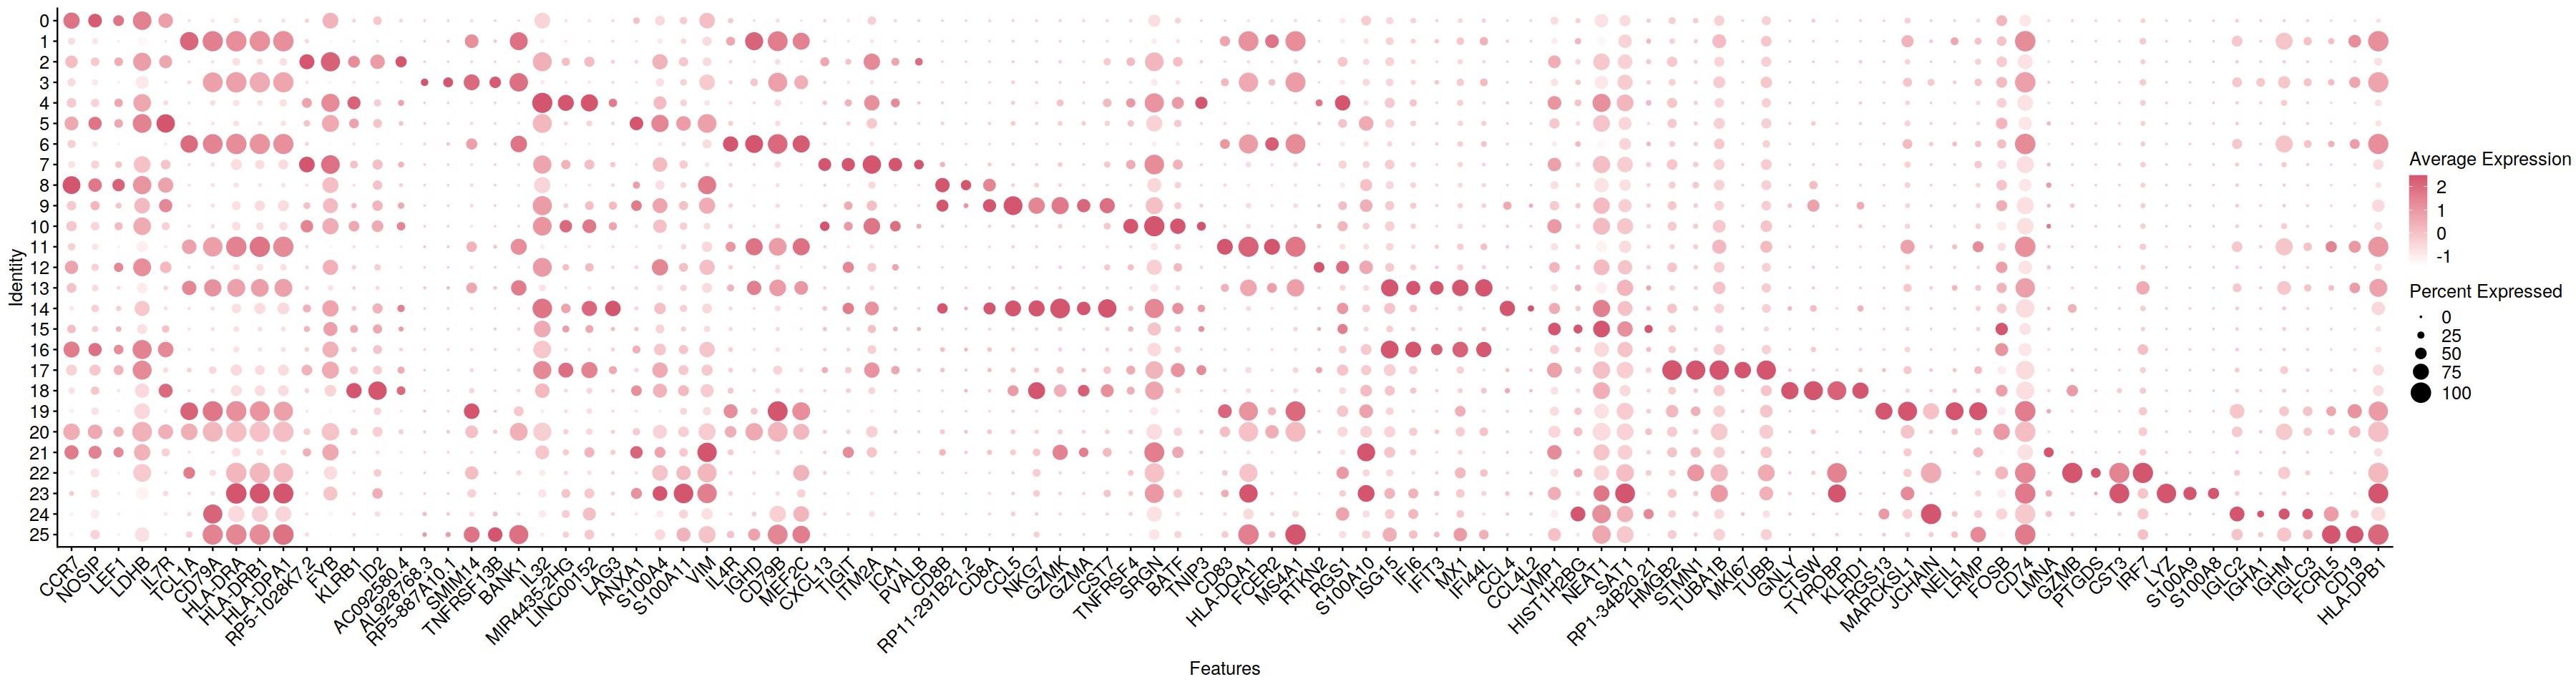

In [76]:
#plot the dotplot
width <- 30
height <- 8
options(repr.plot.width = width, repr.plot.height = height)


plot <- DotPlot(obj_plot, features = unique(markers_plot$gene), dot.scale = 7, cols = c('white', '#D3556E')) + RotatedAxis() +
        theme(
        text = element_text(size = 15),
        axis.text = element_text(size = 15),
        legend.text=element_text(size = 15))
plot
#ggsave(plot, file = './outs/dotplot_clusters.pdf', width = width, height = height)

# Rename cluster idents

In [101]:
#new names:
obj@meta.data$clusters_all <- 'FALSE'

obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 0] <- 'Tn_1'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 1] <- 'B_2'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 2] <- 'CD4m_1'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 3] <- 'B_m'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 4] <- 'Treg_3'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 5] <- 'Tn_2'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 6] <- 'B_3'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 7] <- 'CD4m_2'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 8] <- 'CD8m_1'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 9] <- 'CD8m_2'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 10] <- 'Treg_4'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 11] <- 'B_1'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 12] <- 'Treg_1'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 13] <- 'B_ifn'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 14] <- 'T_exh_1'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 15] <- 'Treg_2'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 16] <- 'T_ifn'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 17] <- 'Proliferative'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 18] <- 'NK-T'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 19] <- 'GCB'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 20] <- 'B_4'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 21] <- 'T_exh_2'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 22] <- 'pDC'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 23] <- 'Macrophage'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 24] <- 'Plasma'
obj@meta.data$clusters_all[obj@meta.data$seurat_clusters == 25] <- 'B_m'

In [102]:
Idents(obj) <- 'clusters_all'

levels(obj) <- c('B_1', 'B_2', 'B_3', 'B_4', 'B_ifn', 'B_m', 'GCB', 'Plasma',
                'pDC', 'Macrophage', 
                'Tn_1', 'Tn_2', 'CD4m_1', 'CD4m_2', 'Treg_1','Treg_2', 'Treg_3', 'Treg_4',
                 'T_ifn',
                 'CD8m_1', 'CD8m_2', 'T_exh_1', 'T_exh_2', 'NK-T', 'Proliferative')

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



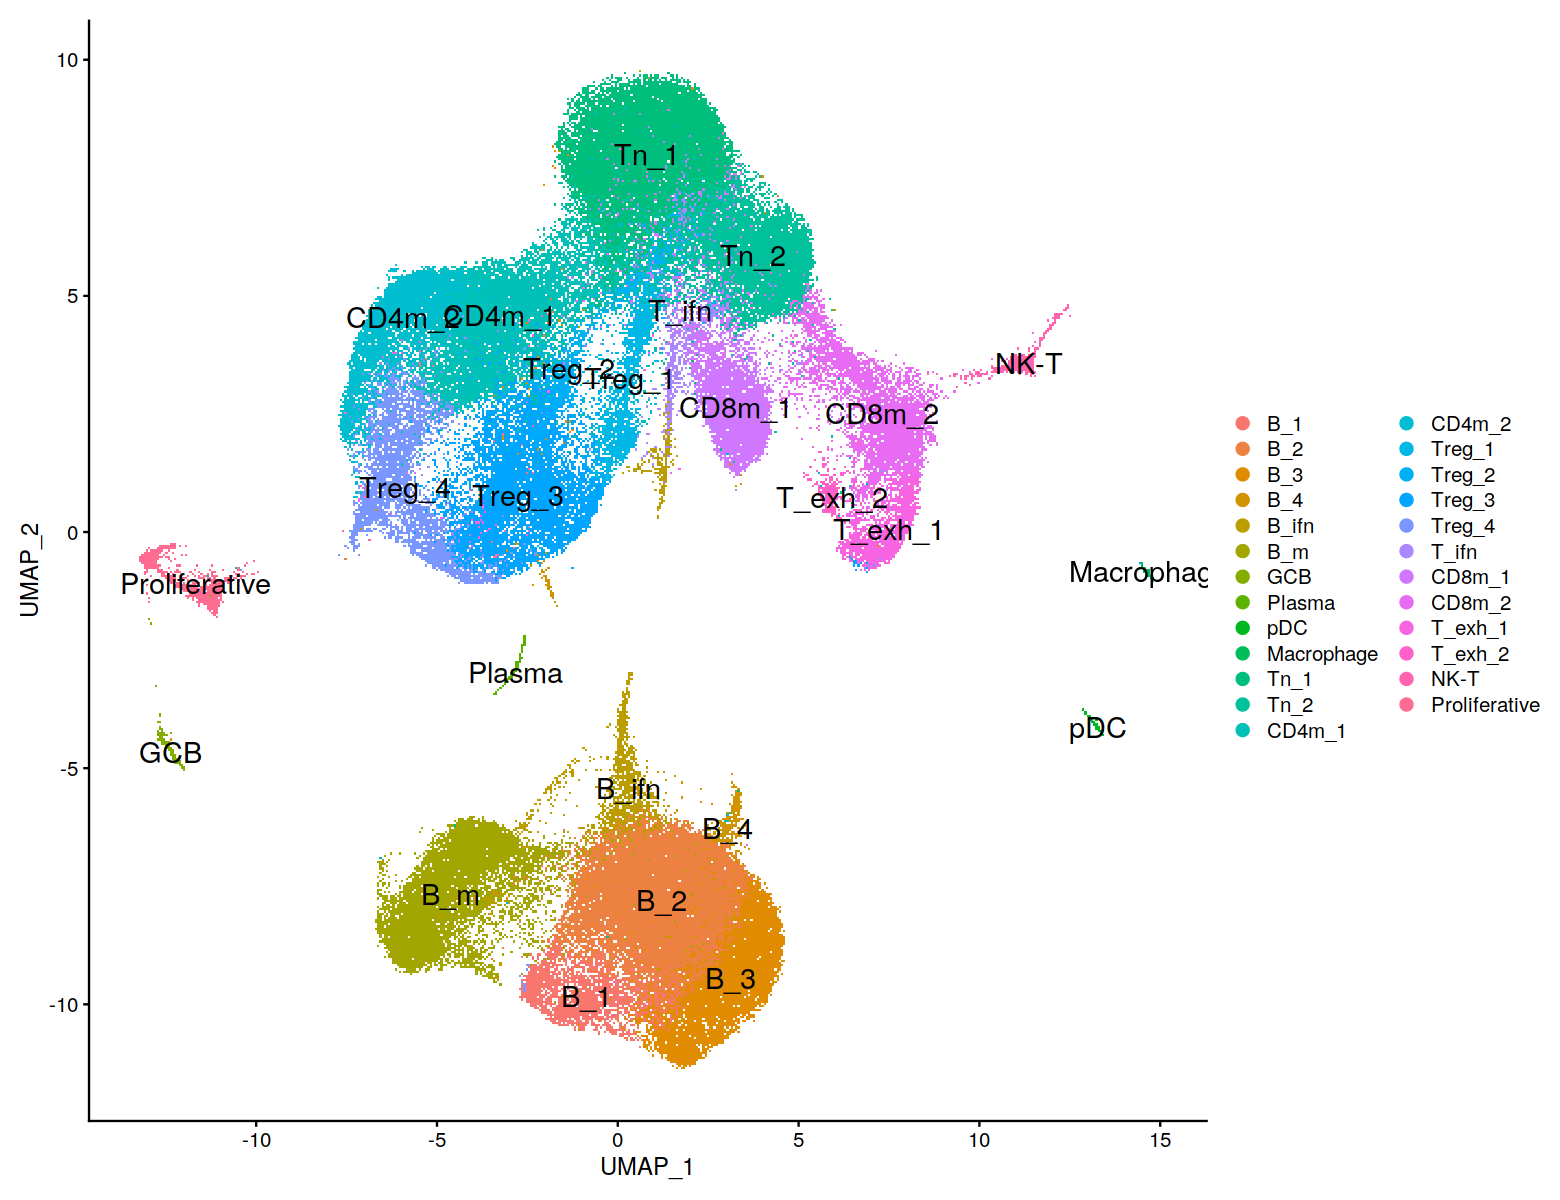

In [105]:
set_figsize(13,10)
fig(DimPlot(obj, reduction = "umap", label=TRUE, label.size=6), 
    "Cluster_UMAP")

In [106]:
saveRDS(obj, file = './rpca_integrated.rds')